In [1]:
debug = True

In [2]:
import csv
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import json
import numpy as np
import random
import os

In [5]:
tf.__version__
seed = 18
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(random)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

ntasks = 5
channels = 18
filters = 3
perceptionsize = 3
neurons = 128
epochs = 200
iterations = 25

2 Physical GPUs, 2 Logical GPUs


In [6]:
ids = {}
names = []

#with os.scandir('/kaggle/input/abstraction-and-reasoning-challenge/') as entries:
#    for entry in entries:
#        names.append("/kaggle/input/abstraction-and-reasoning-challenge/"+entry.name)
with os.scandir('test/') as entries:
    for entry in entries:
        cid = entry.name.replace(".json", "")
        names.append("test/"+entry.name)
        ids["test/"+entry.name] = cid

In [7]:
def load(name):
    X = []
    testcases = []
    Y = []
    with open(name) as json_file:
        data = json.load(json_file) 
        l = len(data['train'])
        i = 0
        for t in data['train']:
            i += 1
            
            cX = np.zeros((30, 30, channels))
            cY = np.zeros((30, 30, channels))
            
            cin = np.array(t['input'])
            cinr = np.full((30, 30), -1)
            cinr[:cin.shape[0], :cin.shape[1]] = cin
            cX[:, :, 0] = cinr
            #! Clone?
            cX[:, :, 1] = cinr
            
            cout = np.array(t['output'])
            coutr = np.full((30, 30), -1)
            coutr[:cout.shape[0], :cout.shape[1]] = cout
            cY[:, :, 0] = coutr
            #! Clone?
            cY[:, :, 1] = coutr
            X.append(cX)
            Y.append(cY)
            
        for t in data['test']:
            i += 1
            
            cX = np.zeros((30, 30, channels))
            cY = np.zeros((30, 30, channels))
            
            cin = np.array(t['input'])
            cinr = np.full((30, 30), -1)
            cinr[:cin.shape[0], :cin.shape[1]] = cin
            cX[:, :, 0] = cinr
            #! Clone?
            cX[:, :, 1] = cinr
            
            testcases.append(cX)

    return [np.array(X), np.array(Y), np.array(testcases)]

In [8]:
for name in names:
    cin = load(name)
    print(name, len(cin[2]))

test/3ed85e70.json 1
test/05a7bcf2.json 1
test/20981f0e.json 1
test/0d87d2a6.json 1
test/1c56ad9f.json 1
test/2a5f8217.json 1
test/31adaf00.json 1
test/2c737e39.json 1
test/15113be4.json 1
test/0c786b71.json 1
test/3d31c5b3.json 1
test/1a6449f1.json 1
test/2c0b0aff.json 1
test/358ba94e.json 1
test/3391f8c0.json 1
test/009d5c81.json 1
test/3194b014.json 1
test/1e81d6f9.json 1
test/0a2355a6.json 1
test/27a77e38.json 1
test/33b52de3.json 1
test/08573cc6.json 1
test/2685904e.json 1
test/18419cfa.json 1
test/2072aba6.json 1
test/0607ce86.json 1
test/256b0a75.json 1
test/0f63c0b9.json 1
test/00576224.json 1
test/1d0a4b61.json 1
test/00dbd492.json 1
test/40f6cd08.json 1
test/12997ef3.json 2
test/12eac192.json 1
test/3ee1011a.json 1
test/423a55dc.json 1
test/292dd178.json 1
test/3b4c2228.json 2
test/0a1d4ef5.json 1
test/0692e18c.json 1
test/070dd51e.json 1
test/1c02dbbe.json 1
test/137f0df0.json 1
test/21f83797.json 1
test/20818e16.json 1
test/0c9aba6e.json 1
test/1acc24af.json 1
test/0bb8deee

In [9]:
import matplotlib.pyplot as plt

if debug:
    def plot(inp):
        plt.imshow(inp[:, :, 0].reshape(30, 30))
        plt.colorbar()
        plt.show()

    def plotf(inp):
        plt.imshow(inp)
        plt.colorbar()
        plt.show()

In [10]:
def loss_f(x, y):
    return tf.reduce_mean(tf.square(x[:, :, :, 0]-y[:, :, :, 0]))

def train(model, ctask, epochs, iterations, channels, verbose=False, validate=False, wholetask=None):
    trainer = tf.keras.optimizers.Adam()

    origx = ctask[0]
    x = origx.copy()
    y = ctask[1]

    mask = np.zeros((x.shape[0], 30, 30, channels))
    mask[:, :, :, 1] = 1
    xl2 = origx*mask

    for k in range(epochs):
        x = origx.copy()
        with tf.GradientTape() as g:
            for i in tf.range(iterations):
                dx = model(x)
                x = x+(dx*1)
                x = x*(1-mask)+xl2
            loss = loss_f(x, y)
            grads = g.gradient(loss, model.weights)
            #grads = [g/(tf.norm(g)+1e-8) for g in grads]
            trainer.apply_gradients(zip(grads, model.weights))

    return model

def generate(model, cin, channels, iterations):
    mask = np.zeros((cin.shape[0], 30, 30, channels))
    mask[:, :, :, 1] = 1
    xl2 = cin*mask
    
    for i in range(iterations):
        dx = model(cin)
        cin = cin+(dx*1)
        cin = cin*(1-mask)+xl2
        if i%10 == 0:
            pass
            #toprint = cin.numpy()[0]
            #plot(toprint)
    
    toprint = cin.numpy()
    return toprint

In [11]:
ntasks = 5
channels = 18
filters = 3
perceptionsize = 3
neurons = 128
epochs = 200

iterations = 25

def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

def solve(taskname):
    models = []
    modelcount = 2

    ntasks = 5
    channels = 18
    filters = 3
    perceptionsize = 3
    neurons = 128
    epochs = 200
    iterations = 25

    ctask = load(taskname)
    cin = [ctask[0], ctask[1]]
    ctest = ctask[2]
    
    if debug:
        plot(ctask[0][0])
        plot(ctask[1][0])
        plot(ctest[0])

    outs = []

    for i in range(modelcount):
        model = tf.keras.Sequential([
            tf.keras.layers.DepthwiseConv2D((perceptionsize, perceptionsize), input_shape=(30, 30, channels), strides=[1, 1], padding="same", depth_multiplier=filters, activation="relu"),
            tf.keras.layers.Conv2D(neurons, 1, activation="relu"),
            tf.keras.layers.Conv2D(channels, 1, activation=None, kernel_initializer=tf.zeros_initializer)
        ])
        model = train(model, cin, epochs, iterations, channels, False, False)
        out = generate(model, ctest, channels, iterations)
        outs.append(out)

    outputs = []
    out = np.array(outs)
    print(out.shape)
    fout = np.clip(np.round(np.mean(out, axis=0)), -1, 9)
    print(fout.shape)
    for task in fout:
        if debug:
            print(task.shape)
            plot(task)
        final = task[:, :, 0]
        x = np.argmin(final[0, :])
        y = np.argmin(final[:, 0])
        cropped = final[:y, :x]
        finalout = flattener(cropped.astype(int).tolist())
        if debug:
            plotf(cropped)
            print(finalout)
        outputs.append(finalout)
    return outputs

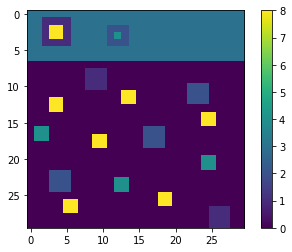

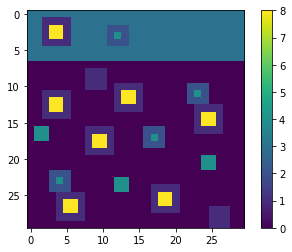

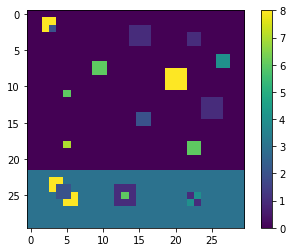


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

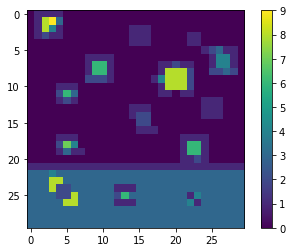

/home/harvey/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  # Remove the CWD from sys.path while we load stuff.
/home/harvey/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  # Remove the CWD from sys.path while we load stuff.


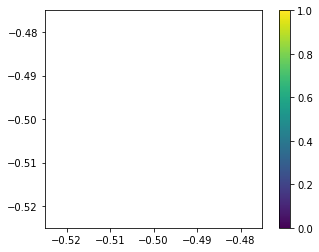

[]


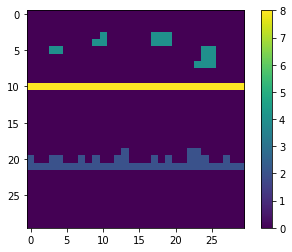

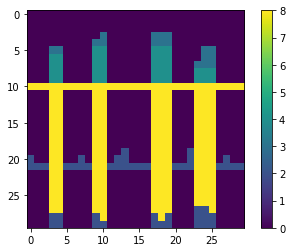

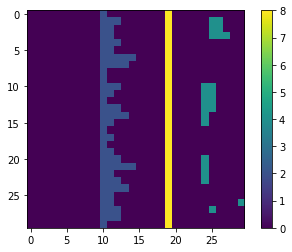


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

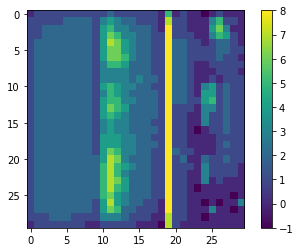

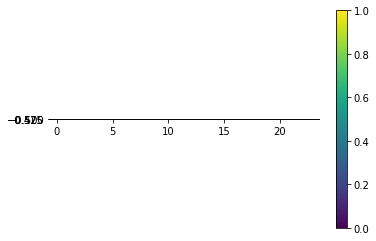

[]


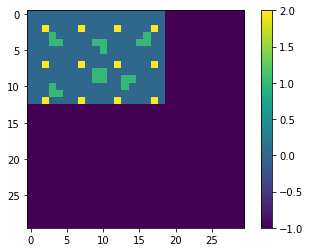

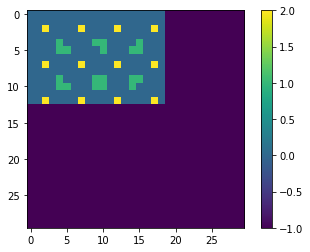

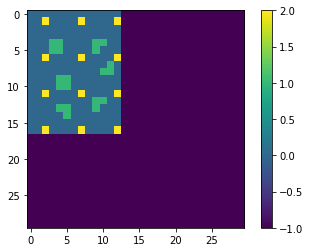


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

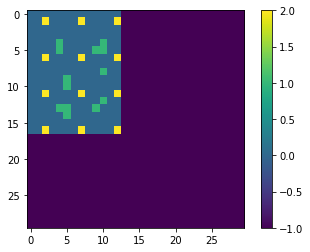

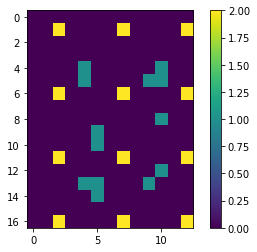

|0000000000000|0020000200002|0000000000000|0000000000000|0000100000100|0000100001100|0020000200002|0000000000000|0000000000100|0000010000000|0000010000000|0020000200002|0000000000100|0000110001000|0000010000000|0000000000000|0020000200002|
20981f0e_0 |0000000000000|0020000200002|0000000000000|0000000000000|0000100000100|0000100001100|0020000200002|0000000000000|0000000000100|0000010000000|0000010000000|0020000200002|0000000000100|0000110001000|0000010000000|0000000000000|0020000200002|


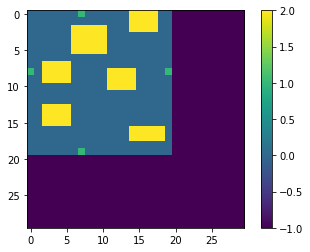

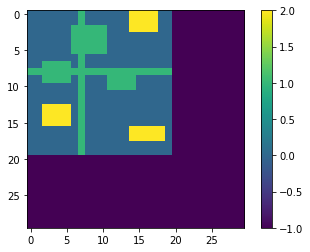

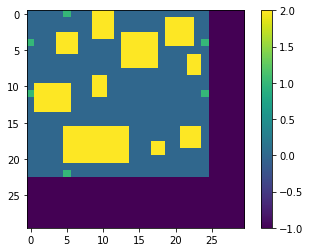


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

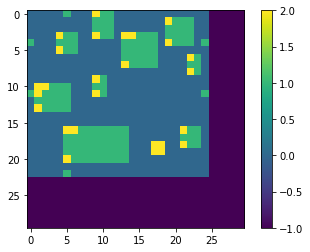

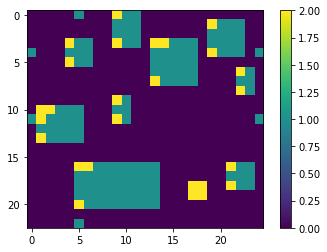

|0000010002110000000000000|0000000001110000000211100|0000000001110000000111100|0000211002110221110111100|1000111000000111110211101|0000211000000111110000000|0000000000000111110000210|0000000000000211110000110|0000000000000000000000210|0000000002100000000000000|0221110001100000000000000|1211110002100000000000001|0111110000000000000000000|0211110000000000000000000|0000000000000000000000000|0000000000000000000000000|0000022111111100000002110|0000011111111100000001110|0000011111111100022002110|0000011111111100022000000|0000021111111100000000000|0000000000000000000000000|0000010000000000000000000|
0d87d2a6_0 |0000010002110000000000000|0000000001110000000211100|0000000001110000000111100|0000211002110221110111100|1000111000000111110211101|0000211000000111110000000|0000000000000111110000210|0000000000000211110000110|0000000000000000000000210|0000000002100000000000000|0221110001100000000000000|1211110002100000000000001|0111110000000000000000000|0211110000000000000000000|000000000000000000000000

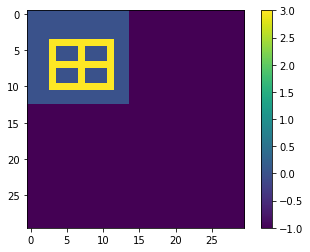

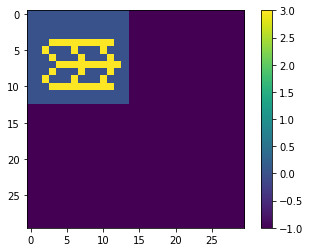

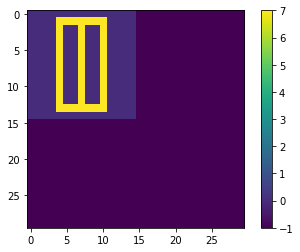


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

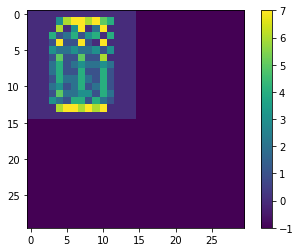

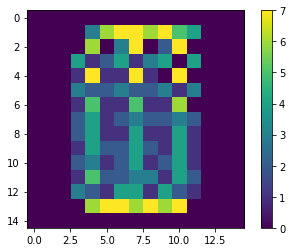

|000000000000000|000036776754000|000060370270000|000412413404000|000171171070000|000322322313000|000151151160000|000241232232000|000241141141000|000142242141000|000231241241000|000152233142000|000321441421000|000067767670000|000000000000000|
1c56ad9f_0 |000000000000000|000036776754000|000060370270000|000412413404000|000171171070000|000322322313000|000151151160000|000241232232000|000241141141000|000142242141000|000231241241000|000152233142000|000321441421000|000067767670000|000000000000000|


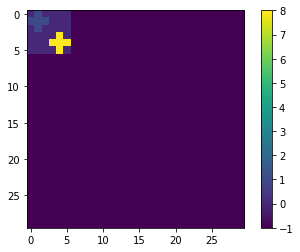

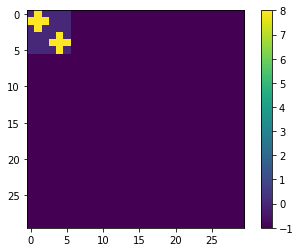

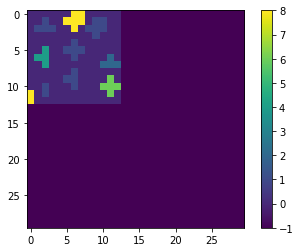


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

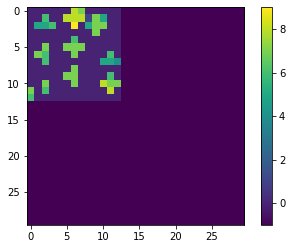

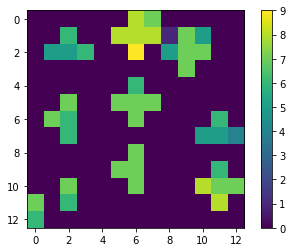

|0000008700000|0060088817500|0556009057700|0000000007000|0000006000000|0070077700000|0760007000060|0060000000554|0000007000000|0000077000060|0070007000877|7060000000080|6000000000000|
2a5f8217_0 |0000008700000|0060088817500|0556009057700|0000000007000|0000006000000|0070077700000|0760007000060|0060000000554|0000007000000|0000077000060|0070007000877|7060000000080|6000000000000|


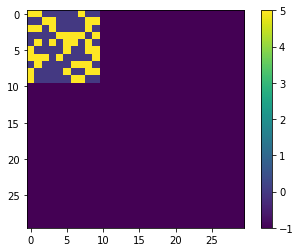

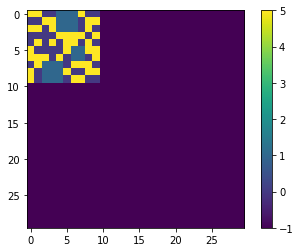

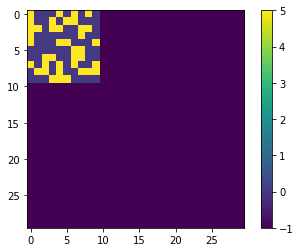


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

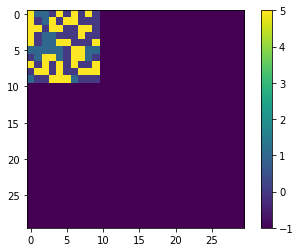

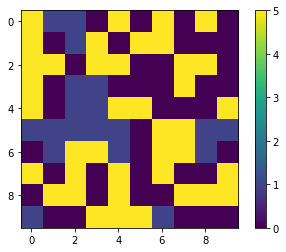

|5110505050|5015055000|5505500550|5011000500|5011550005|1111105511|0155105510|5050505005|0550500555|1005551000|
31adaf00_0 |5110505050|5015055000|5505500550|5011000500|5011550005|1111105511|0155105510|5050505005|0550500555|1005551000|


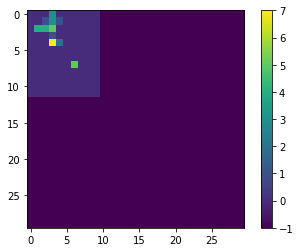

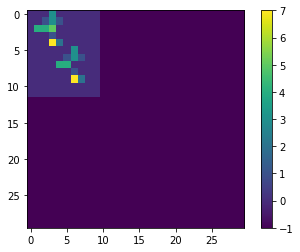

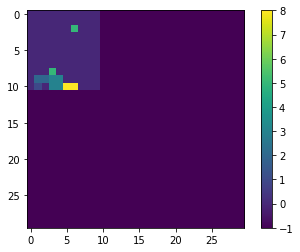


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

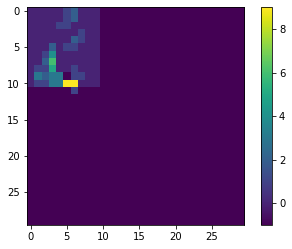

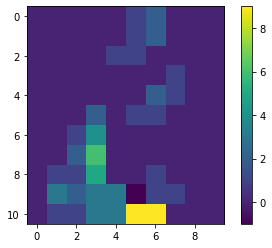

|0000012000|0000012000|0000110000|0000000100|0000002100|0002011000|0014000000|0026000000|0115001000|03233-11100|0113399000|
2c737e39_0 |0000012000|0000012000|0000110000|0000000100|0000002100|0002011000|0014000000|0026000000|0115001000|03233-11100|0113399000|


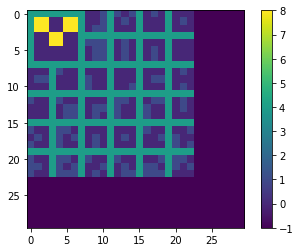

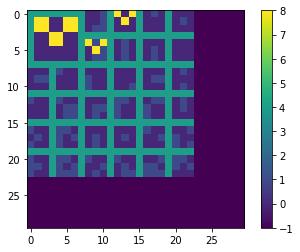

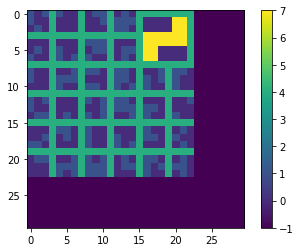


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

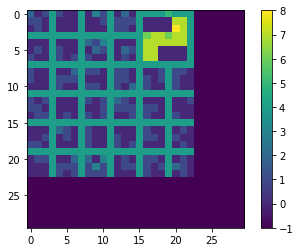

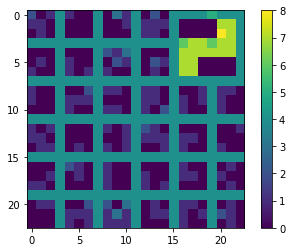

|20141004031402044445444|11040004001411140000774|01040004000411040000874|44444444444444446776774|00040004213400047777774|01041004021402147700004|10041014100401047700004|44444444444444444444444|10040024110411040014110|10041114000411041014100|00041004110410241004100|44444444444444444444444|10140004101421040004001|11040004001411141104000|01140104101400141004100|44444444444444444444444|00042104100400041004010|00140104100410041104100|11040004100410140004010|44444444444444444444444|01140024203401041104010|00041114131401141014210|00041014111400041004010|
15113be4_0 |20141004031402044445444|11040004001411140000774|01040004000411040000874|44444444444444446776774|00040004213400047777774|01041004021402147700004|10041014100401047700004|44444444444444444444444|10040024110411040014110|10041114000411041014100|00041004110410241004100|44444444444444444444444|10140004101421040004001|11040004001411141104000|01140104101400141004100|44444444444444444444444|00042104100400041004010|00140104100410041104100|11

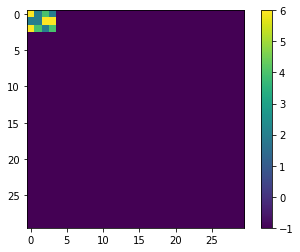

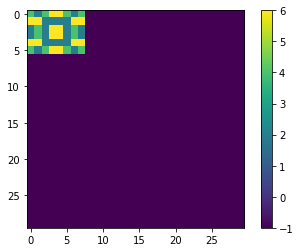

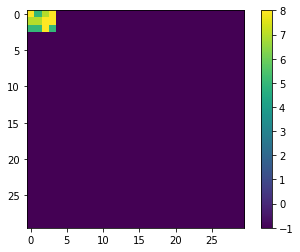


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

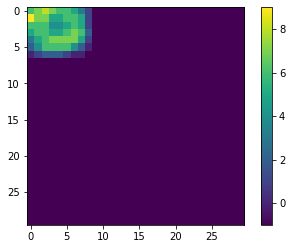

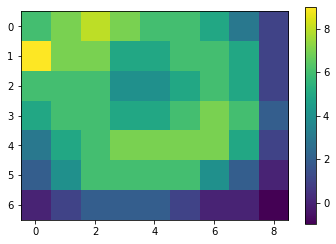

|678766531|977556651|666445651|566556762|356777751|246666420|01222100-1|
0c786b71_0 |678766531|977556651|666445651|566556762|356777751|246666420|01222100-1|


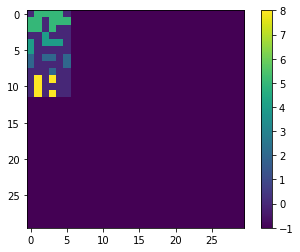

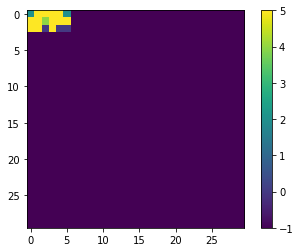

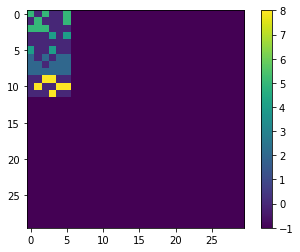


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

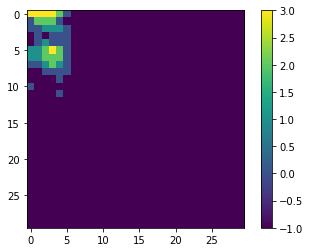

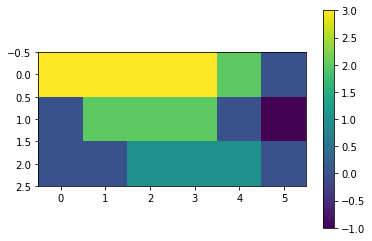

|333320|02220-1|001110|
3d31c5b3_0 |333320|02220-1|001110|


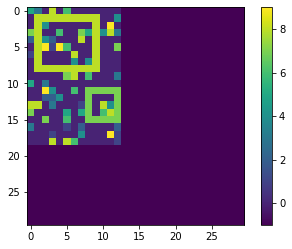

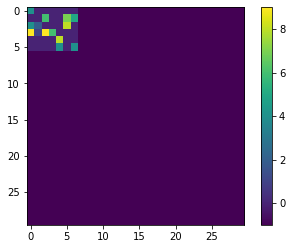

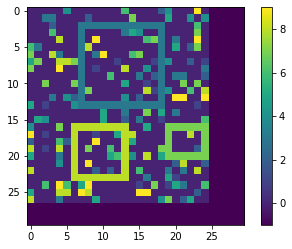


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

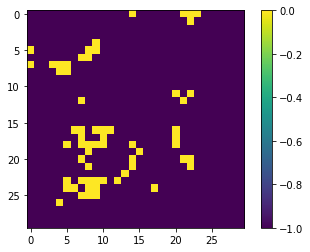

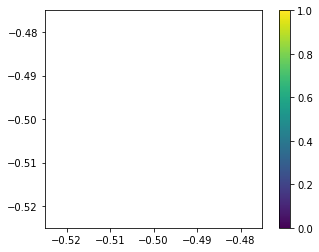

[]


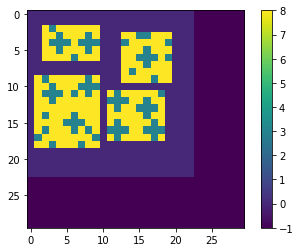

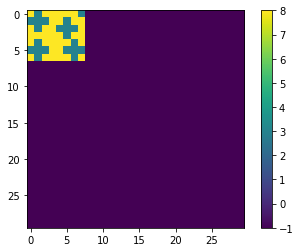

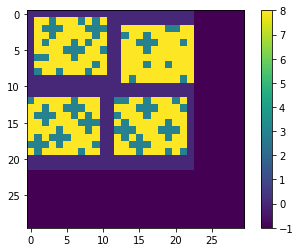


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

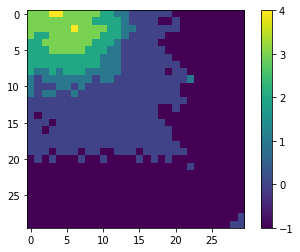

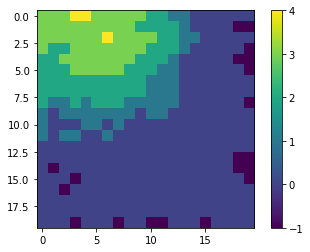

|33344333332211000000|333333333222210000-1-1|33333343333221100000|3223333333222100000-1|223333333222100000-1-1|2223333322211000000-1|22222222221110000000|22222222221110000000|2112122211111000000-1|10111111101100000000|10001101000000000000|10110010000000000000|00000000000000000000|000000000000000000-1-1|0-10000000000000000-1-1|000-1000000000000000-1|00-100000000000000000|00000000000000000000|00000000000000000000|000-1000-100-1-1000-10000|
2c0b0aff_0 |33344333332211000000|333333333222210000-1-1|33333343333221100000|3223333333222100000-1|223333333222100000-1-1|2223333322211000000-1|22222222221110000000|22222222221110000000|2112122211111000000-1|10111111101100000000|10001101000000000000|10110010000000000000|00000000000000000000|000000000000000000-1-1|0-10000000000000000-1-1|000-1000000000000000-1|00-100000000000000000|00000000000000000000|00000000000000000000|000-1000-100-1-1000-10000|


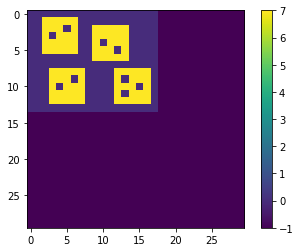

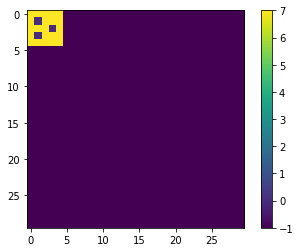

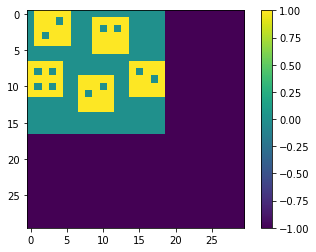


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

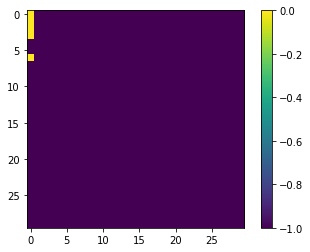

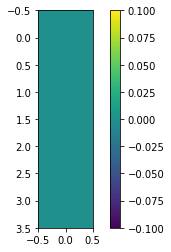

|0|0|0|0|
358ba94e_0 |0|0|0|0|


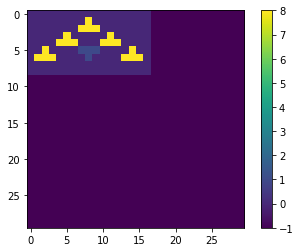

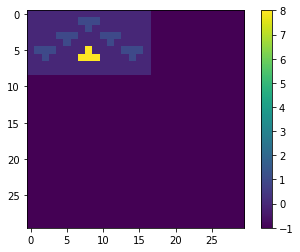

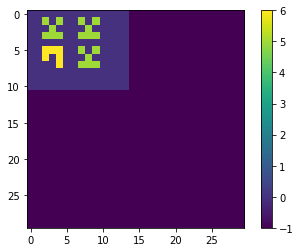


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

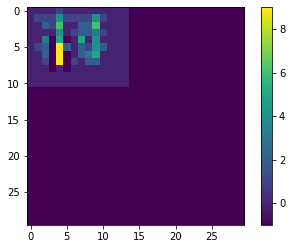

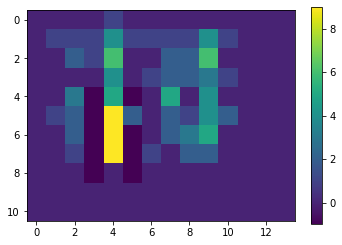

|00001000000000|01114111141000|00216002260000|00004012231000|003-15-105040000|012-19202142000|002-19-102350000|001-19-110220000|000-10-100000000|00000000000000|00000000000000|
3391f8c0_0 |00001000000000|01114111141000|00216002260000|00004012231000|003-15-105040000|012-19202142000|002-19-102350000|001-19-110220000|000-10-100000000|00000000000000|00000000000000|


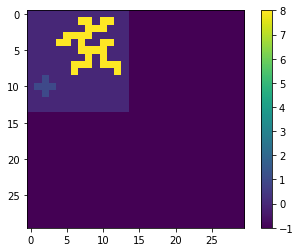

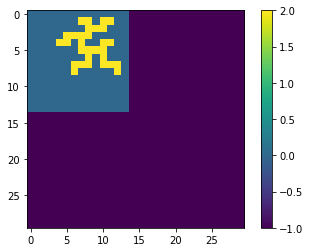

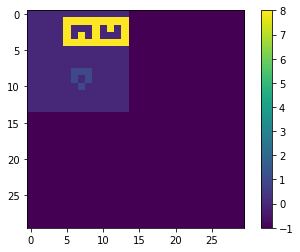


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

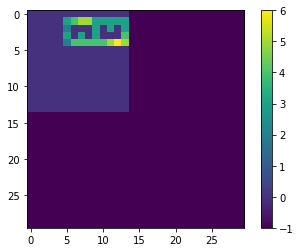

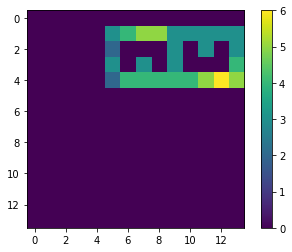

|00000000000000|00000345533333|00000200030303|00000303030004|00000244444565|00000000000000|00000000000000|00000000000000|00000000000000|00000000000000|00000000000000|00000000000000|00000000000000|00000000000000|
009d5c81_0 |00000000000000|00000345533333|00000200030303|00000303030004|00000244444565|00000000000000|00000000000000|00000000000000|00000000000000|00000000000000|00000000000000|00000000000000|00000000000000|00000000000000|


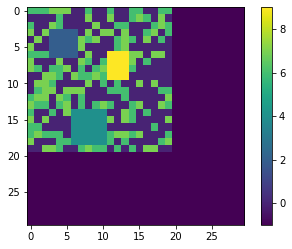

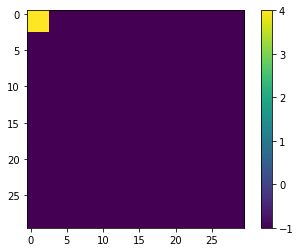

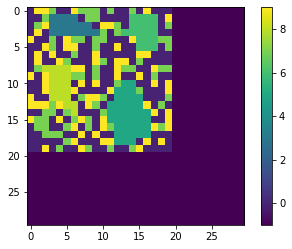


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

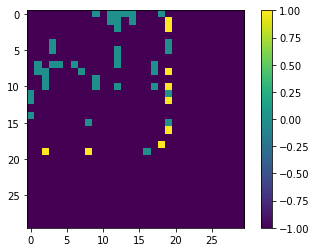

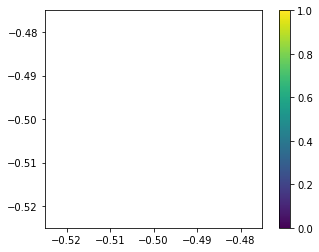

[]


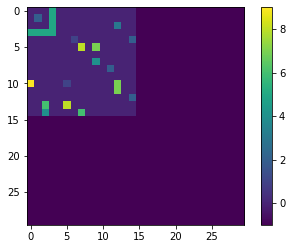

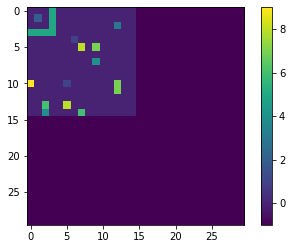

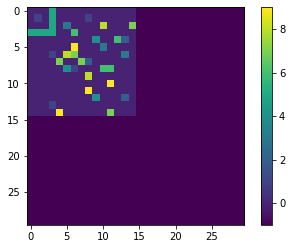


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

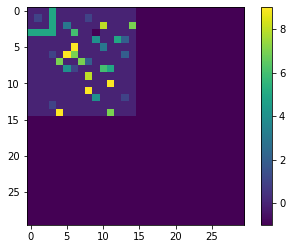

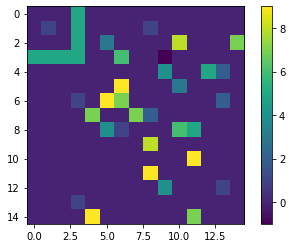

|000500000000000|010500001000000|000503000080007|555500600-100000|000000000400520|000000900030000|000109700000020|000070072000000|000004100065000|000000008000000|000000000009000|000000009000000|000000000400010|000100000000000|000090000007000|
1e81d6f9_0 |000500000000000|010500001000000|000503000080007|555500600-100000|000000000400520|000000900030000|000109700000020|000070072000000|000004100065000|000000008000000|000000000009000|000000009000000|000000000400010|000100000000000|000090000007000|


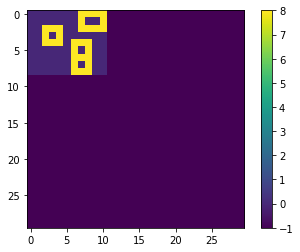

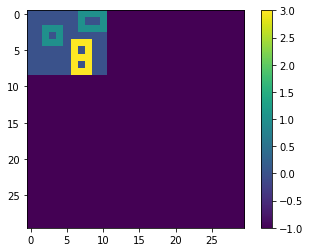

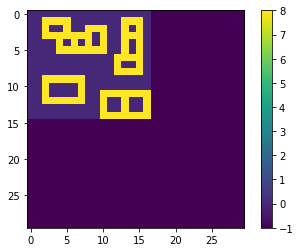


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

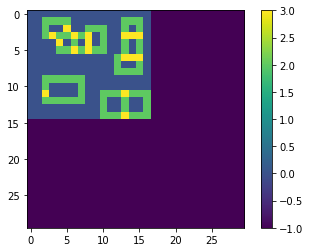

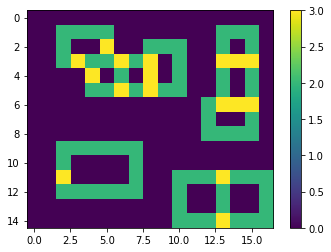

|00000000000000000|00222200000002220|00200300222002020|00232232302003330|00003020302002020|00002232322002020|00000000000023330|00000000000020020|00000000000022220|00222222000000000|00200002000000000|00300002002223222|00222222002002002|00000000002002002|00000000002223222|
0a2355a6_0 |00000000000000000|00222200000002220|00200300222002020|00232232302003330|00003020302002020|00002232322002020|00000000000023330|00000000000020020|00000000000022220|00222222000000000|00200002000000000|00300002002223222|00222222002002002|00000000002002002|00000000002223222|


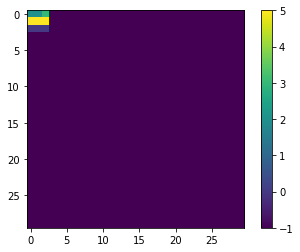

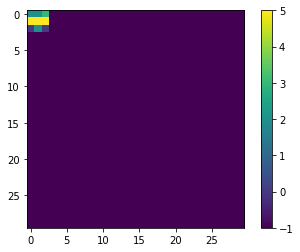

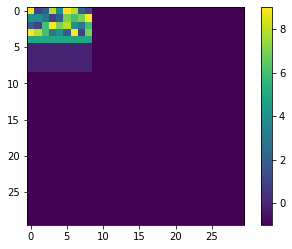


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

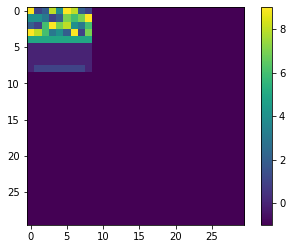

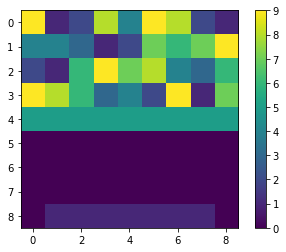

|912849821|443127679|216978436|986342917|555555555|000000000|000000000|000000000|011111110|
27a77e38_0 |912849821|443127679|216978436|986342917|555555555|000000000|000000000|000000000|011111110|


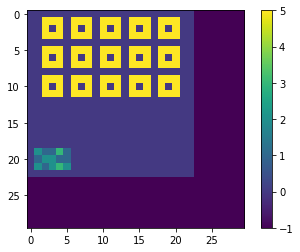

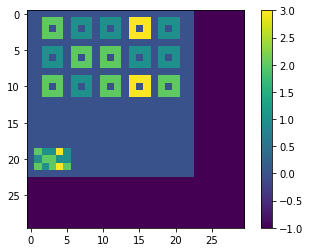

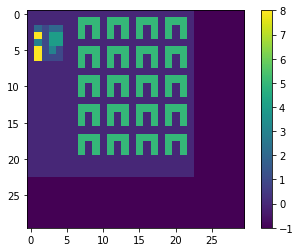


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

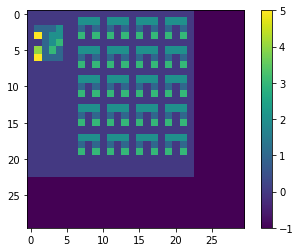

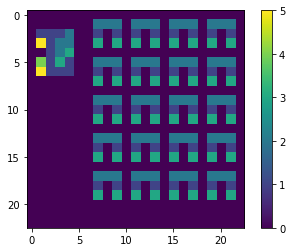

|00000000000000000000000|00000002220222022202220|01112001010101010101010|05122003030303030303030|00123000000000000000000|04131002220222022202220|05111001010101010101010|00000003030303030303030|00000000000000000000000|00000002220222022202220|00000001010101010101010|00000003030303030303030|00000000000000000000000|00000002220222022202220|00000001010101010101010|00000003030303030303030|00000000000000000000000|00000002220222022202220|00000001010101010101010|00000003030303030303030|00000000000000000000000|00000000000000000000000|00000000000000000000000|
33b52de3_0 |00000000000000000000000|00000002220222022202220|01112001010101010101010|05122003030303030303030|00123000000000000000000|04131002220222022202220|05111001010101010101010|00000003030303030303030|00000000000000000000000|00000002220222022202220|00000001010101010101010|00000003030303030303030|00000000000000000000000|00000002220222022202220|00000001010101010101010|00000003030303030303030|00000000000000000000000|00000002220222022202220|00

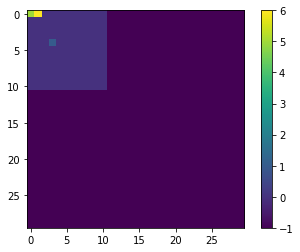

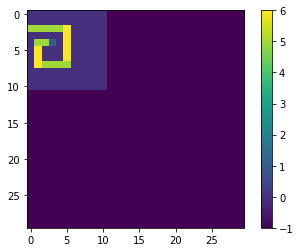

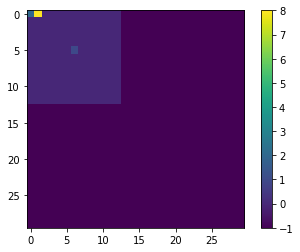


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

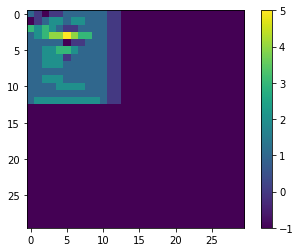

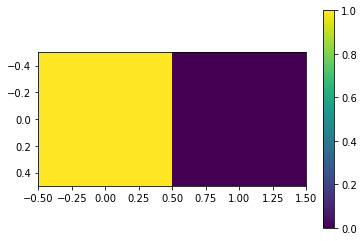

|10|
08573cc6_0 |10|


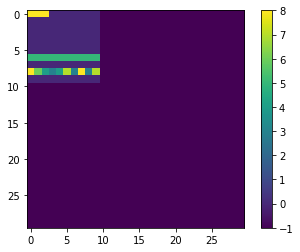

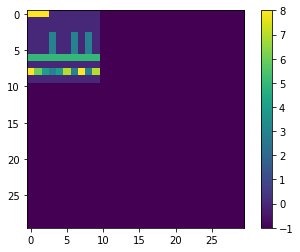

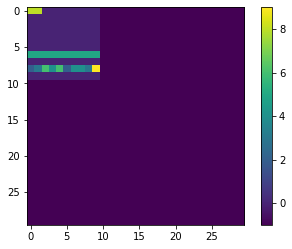


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

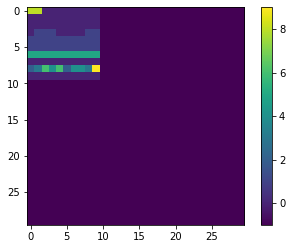

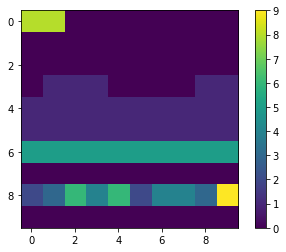

|8800000000|0000000000|0000000000|0111000011|1111111111|1111111111|5555555555|0000000000|2364624439|0000000000|
2685904e_0 |8800000000|0000000000|0000000000|0111000011|1111111111|1111111111|5555555555|0000000000|2364624439|0000000000|


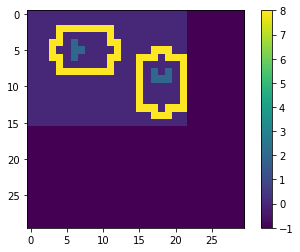

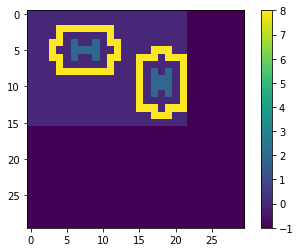

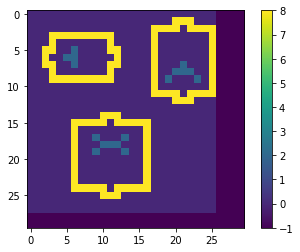


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

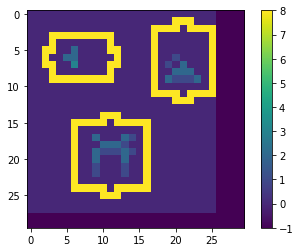

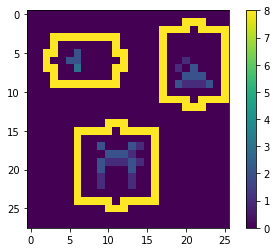

|00000000000000000000000000|00000000000000000000888000|00000000000000000888808888|00088888888800000800000008|00080000000800000800000008|00880020000880000800000008|00800220000080000800100008|00880030000880000801020008|00080000000800000800222008|00088888888800000802111208|00000000000000000800000008|00000000000000000888808888|00000000000000000000888000|00000000000000000000000000|00000000008880000000000000|00000088888088888000000000|00000080000000008000000000|00000080020002108000000000|00000080002221008000000000|00000080021112108000000000|00000080020002008000000000|00000080010001008000000000|00000080010001008000000000|00000080000000008000000000|00000088888088888000000000|00000000008880000000000000|00000000000000000000000000|00000000000000000000000000|
18419cfa_0 |00000000000000000000000000|00000000000000000000888000|00000000000000000888808888|00088888888800000800000008|00080000000800000800000008|00880020000880000800000008|00800220000080000800100008|00880030000880000801020008|00080000000800

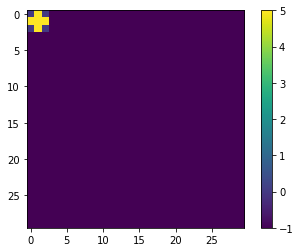

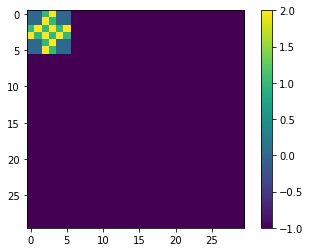

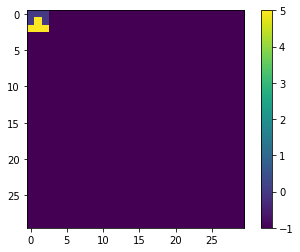


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

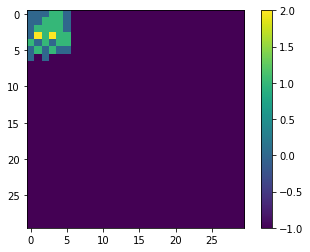

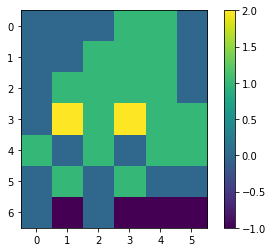

|000110|001110|011110|021211|101011|010100|0-10-1-1-1|
2072aba6_0 |000110|001110|011110|021211|101011|010100|0-10-1-1-1|


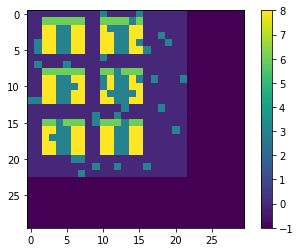

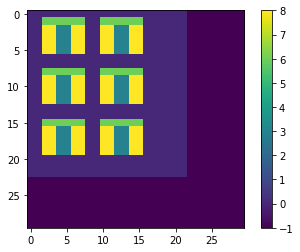

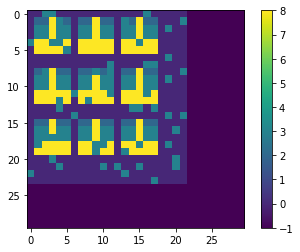


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

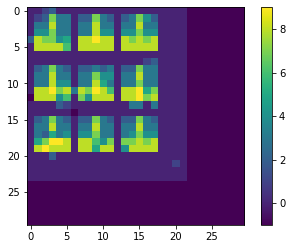

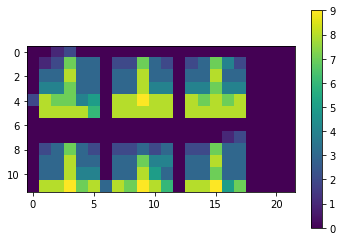

|0012000000000000000000|0127330227320237420000|0338330338330338330000|0447330338440447440000|2877450889880878780000|0888860888880888880000|0000000000000000000000|0000000000000000120000|0237320223230227330000|0338330337440338330000|0338440338530337330000|0889783879860889570000|
0607ce86_0 |0012000000000000000000|0127330227320237420000|0338330338330338330000|0447330338440447440000|2877450889880878780000|0888860888880888880000|0000000000000000000000|0000000000000000120000|0237320223230227330000|0338330337440338330000|0338440338530337330000|0889783879860889570000|


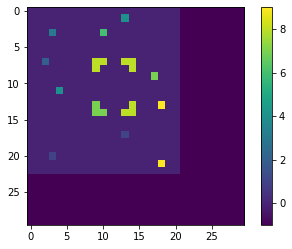

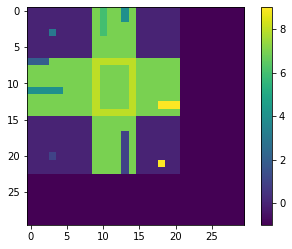

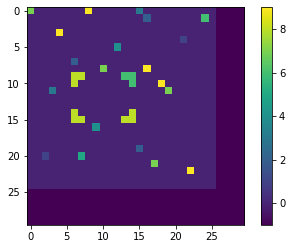


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

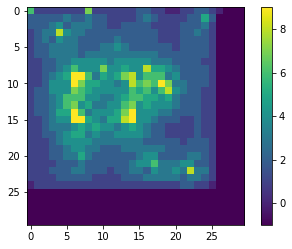

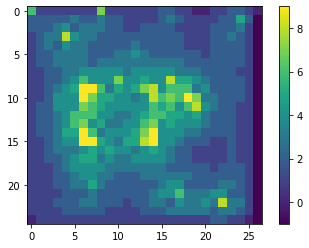

|611111117111111221100112210|22222322322111123211112252-1|22234233322112222111122231-1|12338433222222222211122321-1|12324332222232222211122221-1|12233332223343222222122221-1|12233332333333333322222221-1|11223344444344444333222211-1|11223464447445448554322221-1|11234599635457846663422221-1|11244497554434867697332221-1|12244476544444656468432211-1|12234666443345665545322211-1|12234674533446745444322211-1|12235596344457944433222211-1|11234499543558944322211211-1|11233345454434543221111211-1|11223455343344443221111211-1|11123444433333332222212221-1|11122344332223333332222221-1|11122335322222234422223321-1|11112223222222344633344221-1|11122233222122332433438331-1|11112222211112223333323321-1|01111111111111111111122110-1|
256b0a75_0 |611111117111111221100112210|22222322322111123211112252-1|22234233322112222111122231-1|12338433222222222211122321-1|12324332222232222211122221-1|12233332223343222222122221-1|12233332333333333322222221-1|11223344444344444333222211-1|11223464447445448554322221-1|11

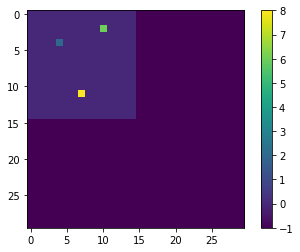

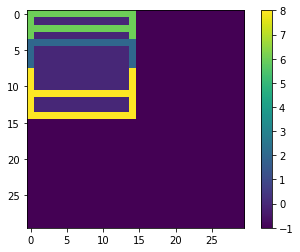

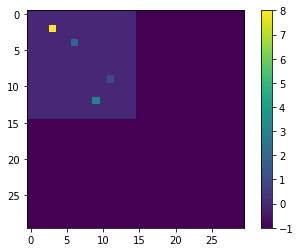


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

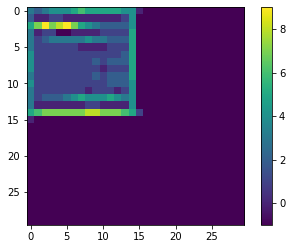

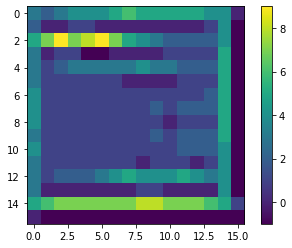

|3234445655555440|200110000000014-1|579789754322224-1|3011-1-1000011115-1|312333334332225-1|311111100001115-1|411111111111125-1|411111111212225-1|411111111101115-1|311111111212225-1|411111111112224-1|311111110111014-1|312223454445434-1|300000001100004-1|5677777788777651|0-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1|
0f63c0b9_0 |3234445655555440|200110000000014-1|579789754322224-1|3011-1-1000011115-1|312333334332225-1|311111100001115-1|411111111111125-1|411111111212225-1|411111111101115-1|311111111212225-1|411111111112224-1|311111110111014-1|312223454445434-1|300000001100004-1|5677777788777651|0-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1|


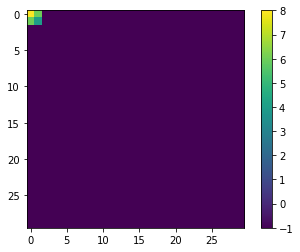

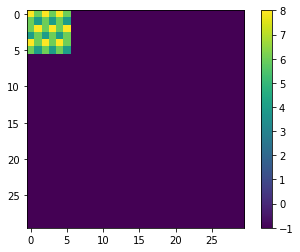

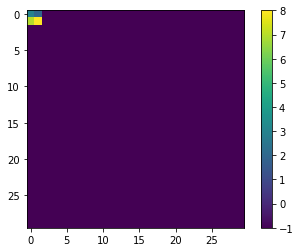


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

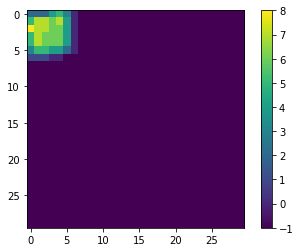

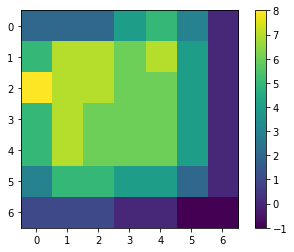

|2224530|5776740|8776640|5766640|5766640|3554420|11100-1-1|
00576224_0 |2224530|5776740|8776640|5766640|5766640|3554420|11100-1-1|


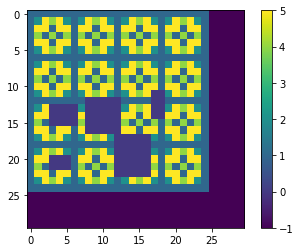

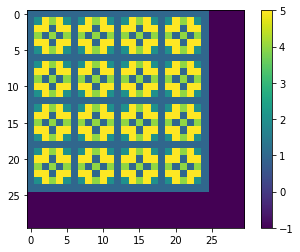

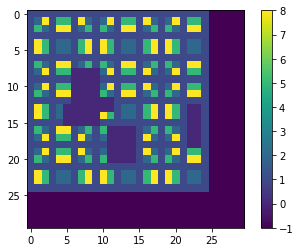


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

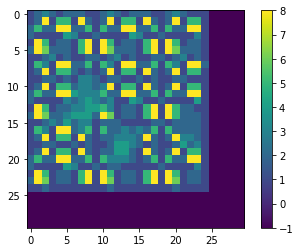

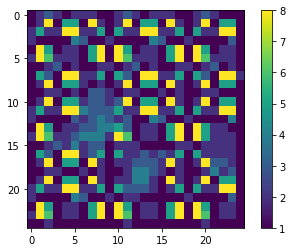

|1232122211232122211232111|1281551821281551821281551|2522882251522882251522881|2111143112111143112111131|1851221581851221581851221|2862221581862221581862221|1123121122123121122123121|1531882251531882251531882|1281552121281551821281551|1122121332122112121122111|1281552332381551821281551|2522884333522882251522881|2111132343231143112111141|1851223344531221581852211|2862234442861221581852221|1123242331222111122122221|1531882351522323251522221|1281551821223332821283321|1122112121124432121124231|1281551821224421821281551|2522882251533321251522881|2111143112122111112111131|1851221581851221581851221|2861221581861221581861221|1121111111121111111121111|
1d0a4b61_0 |1232122211232122211232111|1281551821281551821281551|2522882251522882251522881|2111143112111143112111131|1851221581851221581851221|2862221581862221581862221|1123121122123121122123121|1531882251531882251531882|1281552121281551821281551|1122121332122112121122111|1281552332381551821281551|2522884333522882251522881|211113234323114311211114

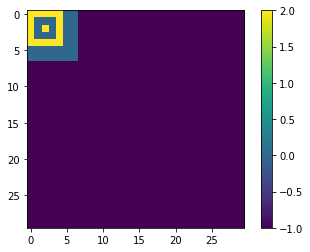

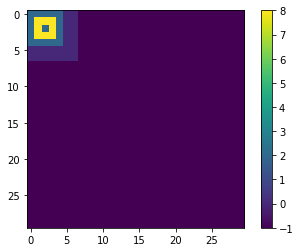

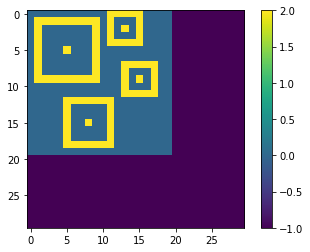


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

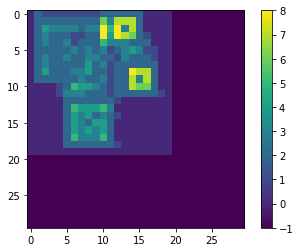

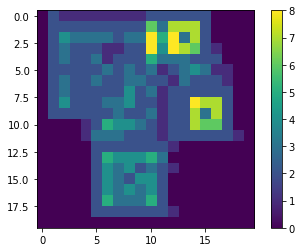

|02111111112222220000|02222222226377720000|02433332338583720000|02322211228487621000|02322312225333222000|02222232323123431100|02322322332213222100|02322222423122222200|02422233422122877200|02222223223122737200|00001254432122766200|00001333222122222210|00000222222210000000|00000254445300000000|00000243423210000000|00000243244200000000|00000243434200000000|00000253335200000000|00000222222210000000|00000000000000000000|
00dbd492_0 |02111111112222220000|02222222226377720000|02433332338583720000|02322211228487621000|02322312225333222000|02222232323123431100|02322322332213222100|02322222423122222200|02422233422122877200|02222223223122737200|00001254432122766200|00001333222122222210|00000222222210000000|00000254445300000000|00000243423210000000|00000243244200000000|00000243434200000000|00000253335200000000|00000222222210000000|00000000000000000000|


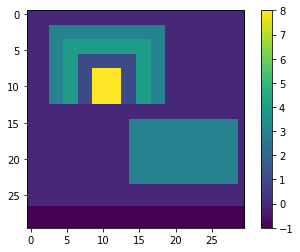

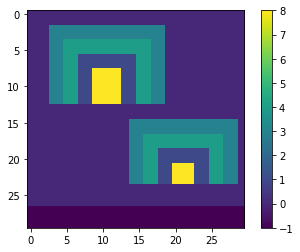

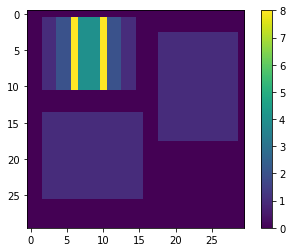


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

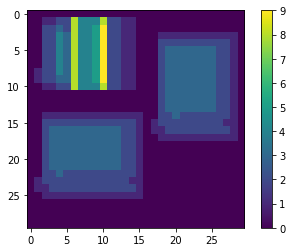

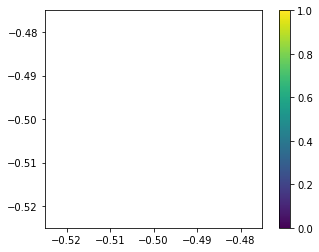

[]


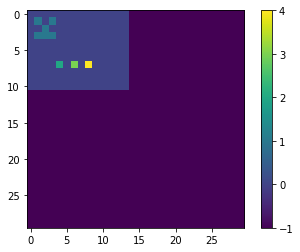

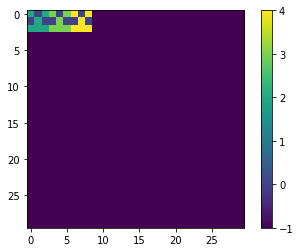

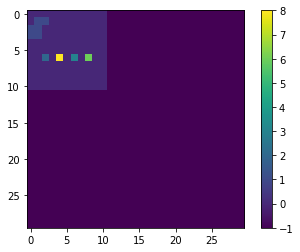


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 2, 30, 30, 1

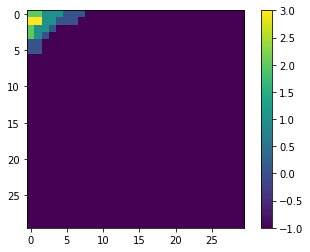

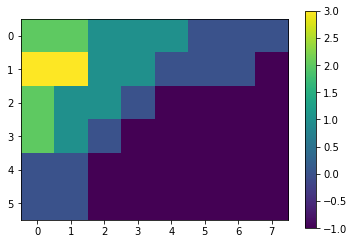

|22111000|3311000-1|2110-1-1-1-1|210-1-1-1-1-1|00-1-1-1-1-1-1|00-1-1-1-1-1-1|
(30, 30, 18)


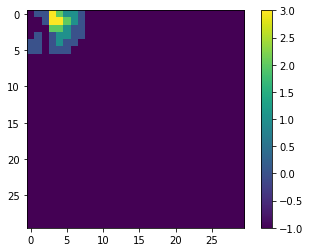

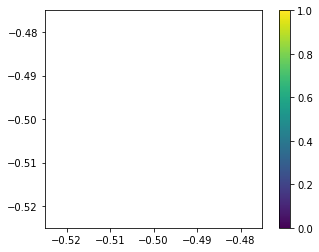

[]
12997ef3_0 |22111000|3311000-1|2110-1-1-1-1|210-1-1-1-1-1|00-1-1-1-1-1-1|00-1-1-1-1-1-1|


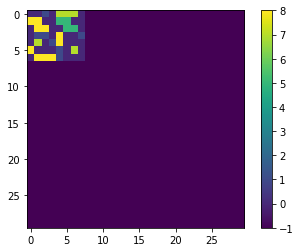

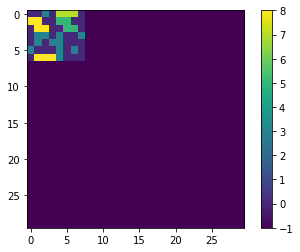

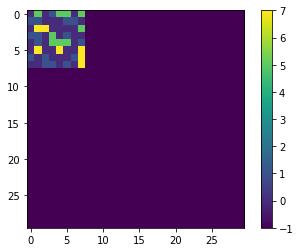


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

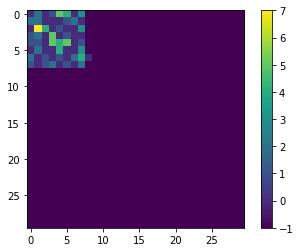

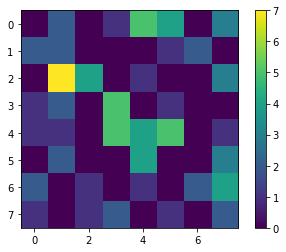

|02015403|22000120|07401003|12050100|11054501|02004003|20101024|10120102|
12eac192_0 |02015403|22000120|07401003|12050100|11054501|02004003|20101024|10120102|


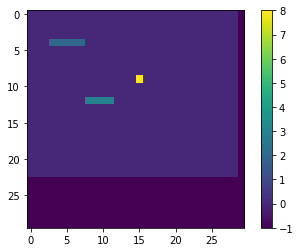

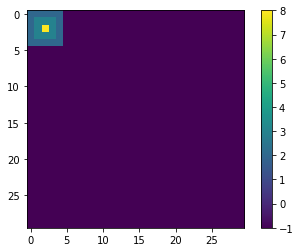

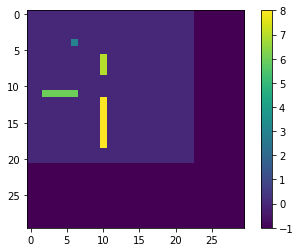


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

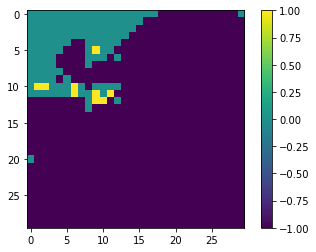

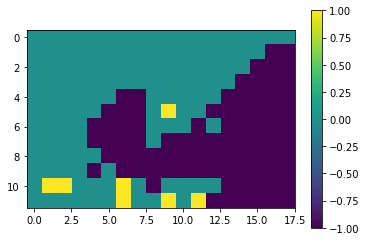

|000000000000000000|0000000000000000-1-1|000000000000000-1-1-1|00000000000000-1-1-1-1|000000-1-100000-1-1-1-1-1|00000-1-1-10100-1-1-1-1-1-1|0000-1-1-1-1000-10-1-1-1-1-1|0000-1-1-1-10-1-1-1-1-1-1-1-1-1|00000-1-1-1-1-1-1-1-1-1-1-1-1-1|0000-10-1-1-1-1-1-1-1-1-1-1-1-1|01100010-10000-1-1-1-1-1|000000100101-1-1-1-1-1-1|
3ee1011a_0 |000000000000000000|0000000000000000-1-1|000000000000000-1-1-1|00000000000000-1-1-1-1|000000-1-100000-1-1-1-1-1|00000-1-1-10100-1-1-1-1-1-1|0000-1-1-1-1000-10-1-1-1-1-1|0000-1-1-1-10-1-1-1-1-1-1-1-1-1|00000-1-1-1-1-1-1-1-1-1-1-1-1-1|0000-10-1-1-1-1-1-1-1-1-1-1-1-1|01100010-10000-1-1-1-1-1|000000100101-1-1-1-1-1-1|


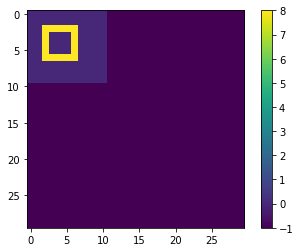

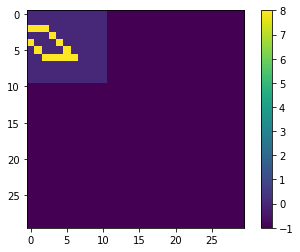

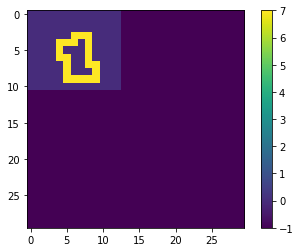


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

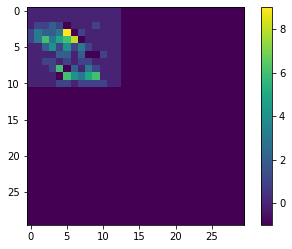

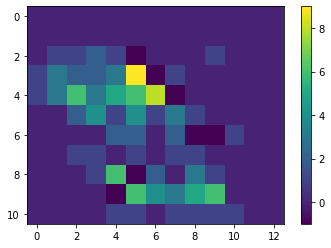

|0000000000000|0000000000000|01121-10001000|132239-1100000|1363568-100000|0024141310000|00002202-1-1100|0011010110000|00016-12031000|0000-164356000|0000110111100|
423a55dc_0 |0000000000000|0000000000000|01121-10001000|132239-1100000|1363568-100000|0024141310000|00002202-1-1100|0011010110000|00016-12031000|0000-164356000|0000110111100|


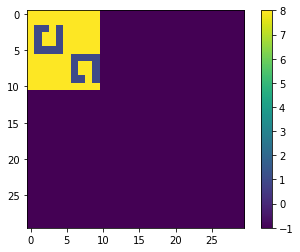

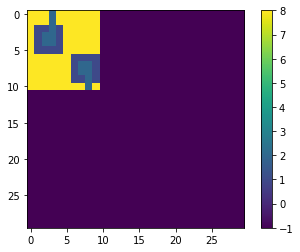

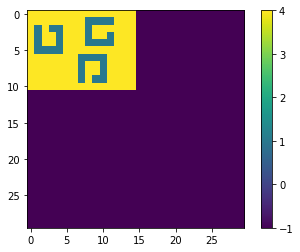


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

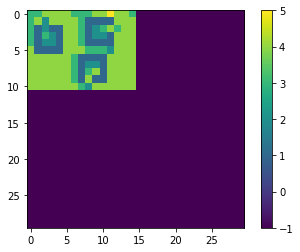

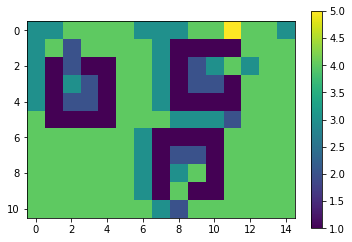

|334444333445443|342444431111444|312114431234344|313214431221444|312214431111444|411114443332444|444444311114444|444444312214444|444444313414444|444444314114444|444444432444444|
292dd178_0 |334444333445443|342444431111444|312114431234344|313214431221444|312214431111444|411114443332444|444444311114444|444444312214444|444444313414444|444444314114444|444444432444444|


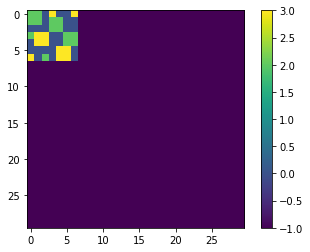

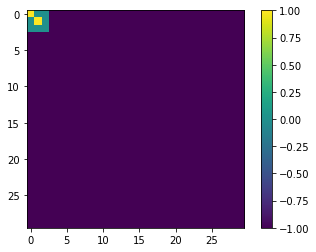

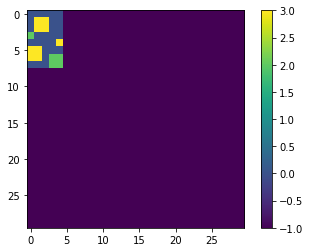


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 2, 30, 30, 1

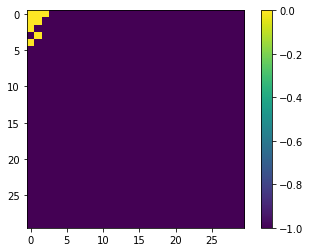

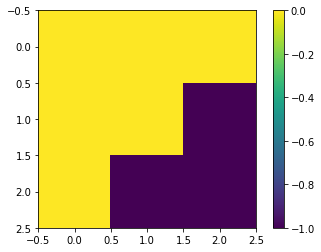

|000|00-1|0-1-1|
(30, 30, 18)


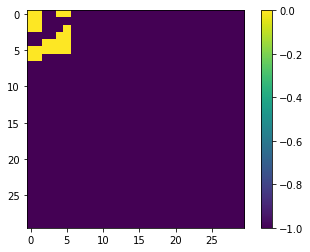

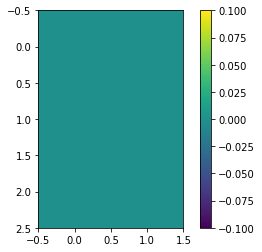

|00|00|00|
3b4c2228_0 |000|00-1|0-1-1|
3b4c2228_1 |00|00|00|


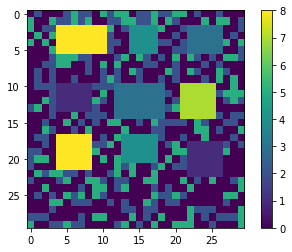

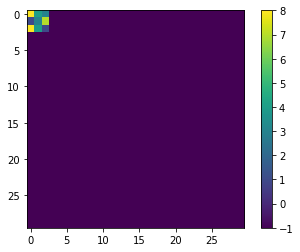

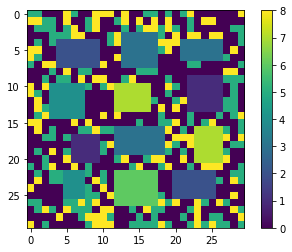


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

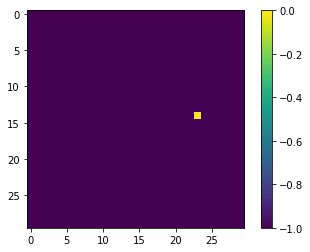

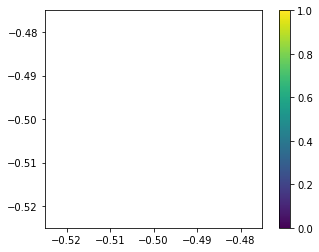

[]


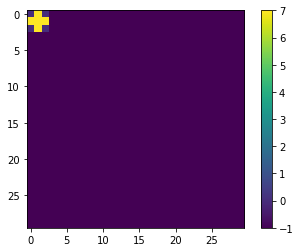

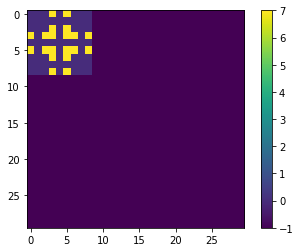

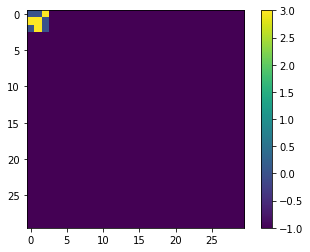


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

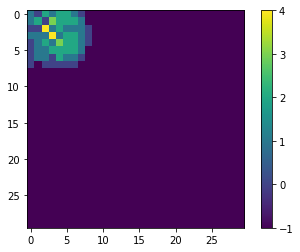

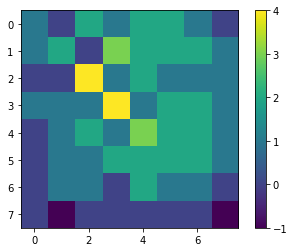

|10212210|12032221|00412111|11141221|01213221|01122221|01102110|0-100000-1|
0692e18c_0 |10212210|12032221|00412111|11141221|01213221|01122221|01102110|0-100000-1|


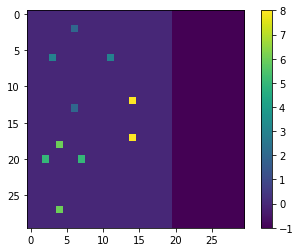

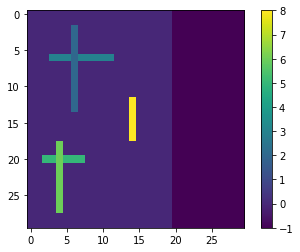

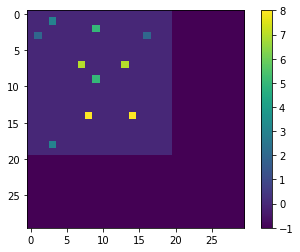


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

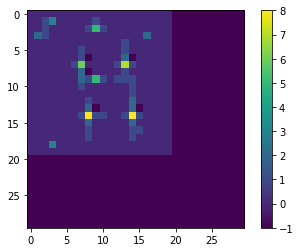

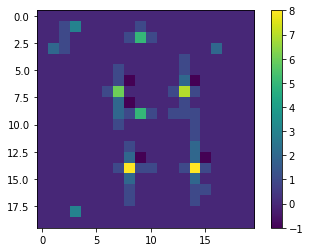

|00000000000000000000|00130000010000000000|00100000151000000000|02100000000000002000|00000000000001000000|00000001000001000000|00000001-100002-100000|00000016000017100000|00000002-100001000000|00000002151011100000|00000001000000100000|00000000000000100000|00000000100000200000|000000002-100002-10000|00000001811001810000|00000000200000200000|00000000100000110000|00000000100000100000|00030000000000000000|00000000000000000000|
070dd51e_0 |00000000000000000000|00130000010000000000|00100000151000000000|02100000000000002000|00000000000001000000|00000001000001000000|00000001-100002-100000|00000016000017100000|00000002-100001000000|00000002151011100000|00000001000000100000|00000000000000100000|00000000100000200000|000000002-100002-10000|00000001811001810000|00000000200000200000|00000000100000110000|00000000100000100000|00030000000000000000|00000000000000000000|


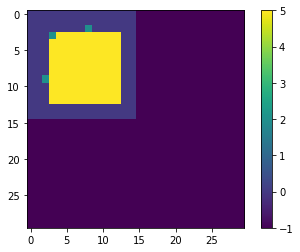

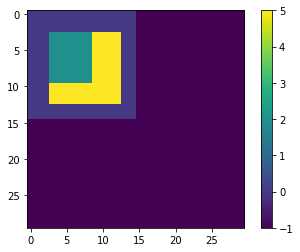

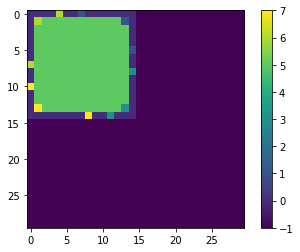


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

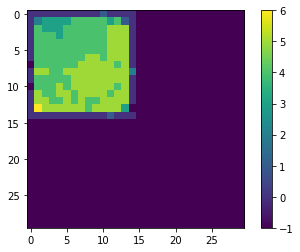

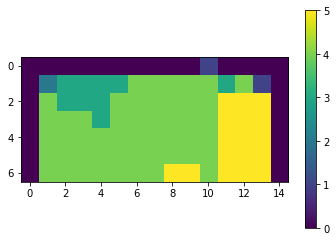

|000000000010000|023333444443410|043334444445550|044434444445550|044444444445550|044444444445550|044444445545550|
1c02dbbe_0 |000000000010000|023333444443410|043334444445550|044434444445550|044444444445550|044444444445550|044444445545550|


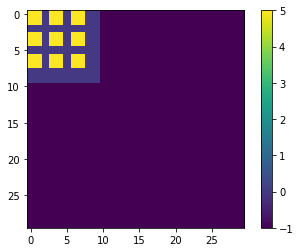

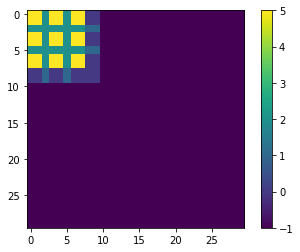

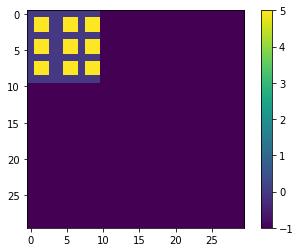


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

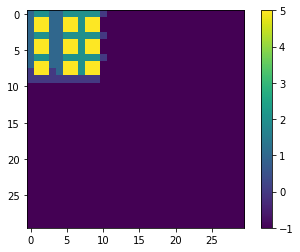

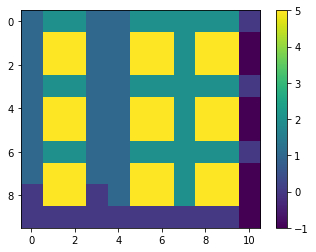

|12211222220|1551155255-1|1551155255-1|12211222220|1551155255-1|1551155255-1|12211222220|1551155255-1|0550155255-1|0000000000-1|
137f0df0_0 |12211222220|1551155255-1|1551155255-1|12211222220|1551155255-1|1551155255-1|12211222220|1551155255-1|0550155255-1|0000000000-1|


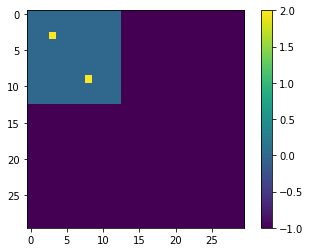

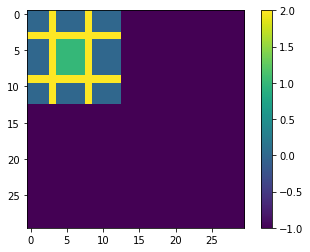

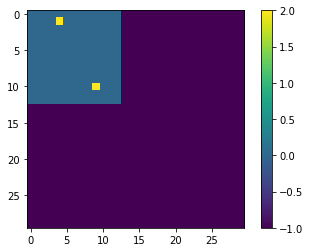


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

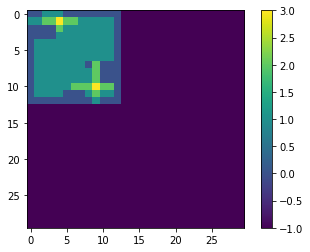

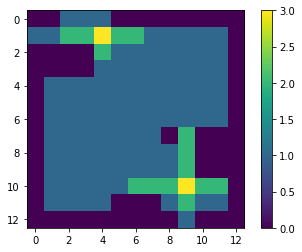

|0011100000000|1122322111110|0000211111110|0000111111110|0111111111110|0111111111110|0111111111110|0111111102000|0111111112000|0111111112000|0111112223220|0111100012110|0000000001000|
21f83797_0 |0011100000000|1122322111110|0000211111110|0000111111110|0111111111110|0111111111110|0111111111110|0111111102000|0111111112000|0111111112000|0111112223220|0111100012110|0000000001000|


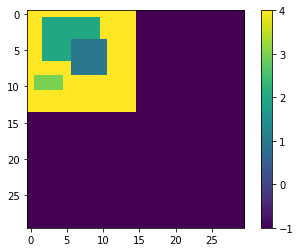

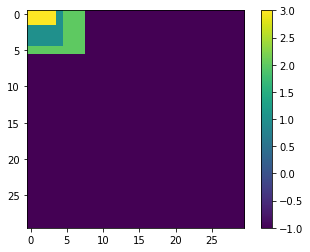

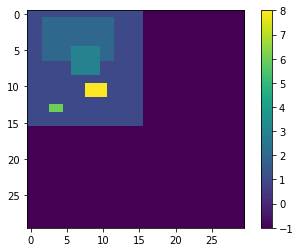


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

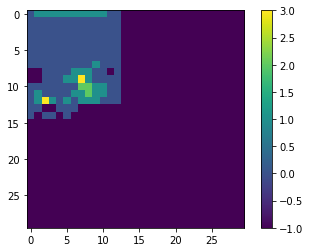

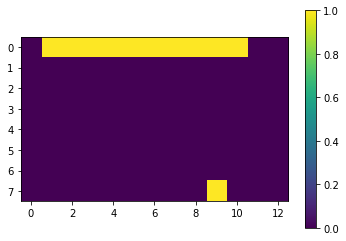

|0111111111100|0000000000000|0000000000000|0000000000000|0000000000000|0000000000000|0000000000000|0000000001000|
20818e16_0 |0111111111100|0000000000000|0000000000000|0000000000000|0000000000000|0000000000000|0000000000000|0000000001000|


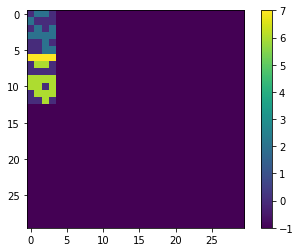

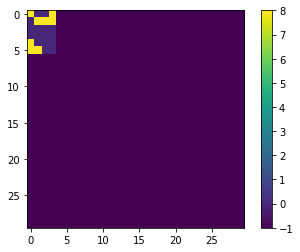

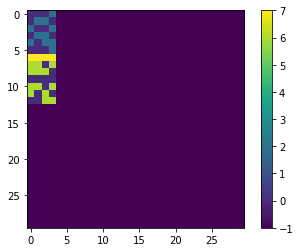


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

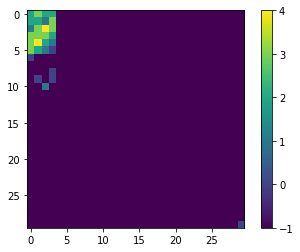

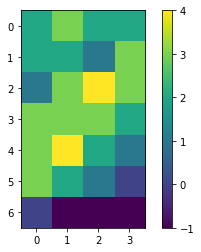

|2322|2213|1343|3332|3421|3210|0-1-1-1|
0c9aba6e_0 |2322|2213|1343|3332|3421|3210|0-1-1-1|


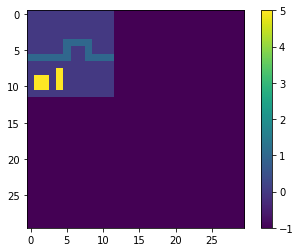

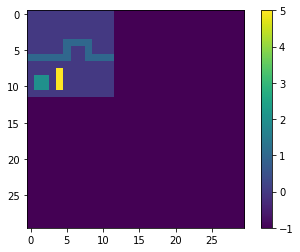

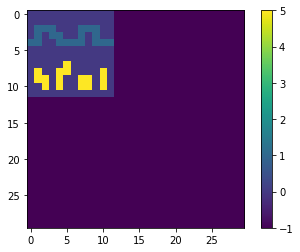


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

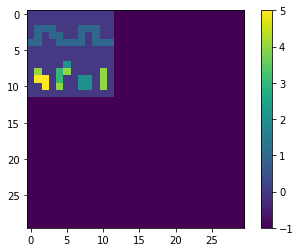

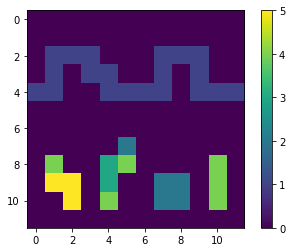

|000000000000|000000000000|011100011100|010110010100|110011110111|000000000000|000000000000|000002000000|040034000040|055030022040|005040022040|000000000000|
1acc24af_0 |000000000000|000000000000|011100011100|010110010100|110011110111|000000000000|000000000000|000002000000|040034000040|055030022040|005040022040|000000000000|


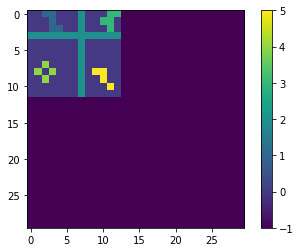

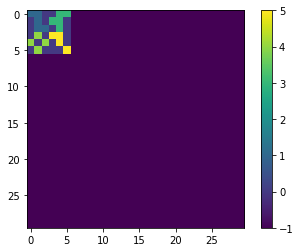

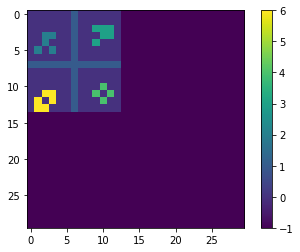


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

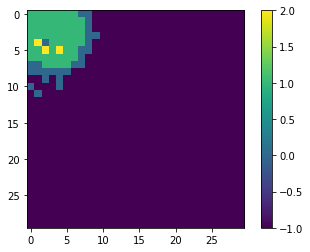

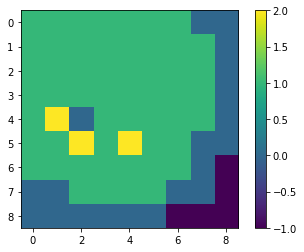

|111111100|111111110|111111110|111111110|120111110|112121100|11111110-1|00111100-1|000000-1-1-1|
0bb8deee_0 |111111100|111111110|111111110|111111110|120111110|112121100|11111110-1|00111100-1|000000-1-1-1|


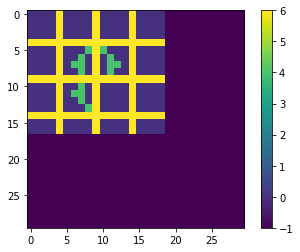

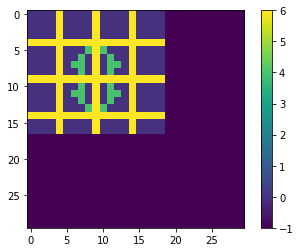

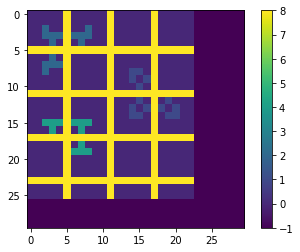


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

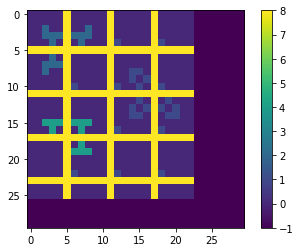

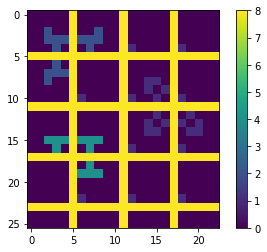

|00000800000800000800000|00000800000800000800000|00200800200800000800000|00222822200800000800000|00020802000810000810000|88888888888888888888888|00020800000800000800000|00222800000800000800000|00200800000800110800000|00000800000800101800000|00000810000810010810000|88888888888888888888888|00000800000800010801000|00000800000800101810100|00000800000800110801100|00444844400800000800000|00040804000810000810000|88888888888888888888888|00000804000800000800000|00000844400800000800000|00000800000800000800000|00000800000800000800000|00000810000810000810000|88888888888888888888888|00000800000800000800000|00000800000800000800000|
2546ccf6_0 |00000800000800000800000|00000800000800000800000|00200800200800000800000|00222822200800000800000|00020802000810000810000|88888888888888888888888|00020800000800000800000|00222800000800000800000|00200800000800110800000|00000800000800101800000|00000810000810010810000|88888888888888888888888|00000800000800010801000|00000800000800101810100|00000800000800110801100|00

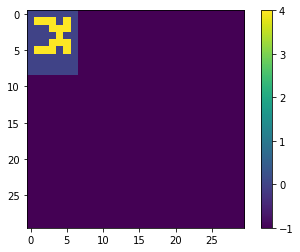

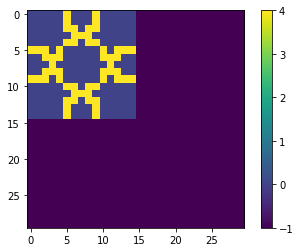

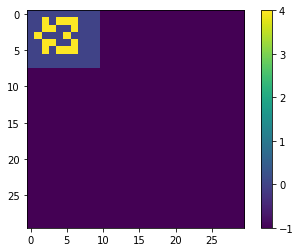


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

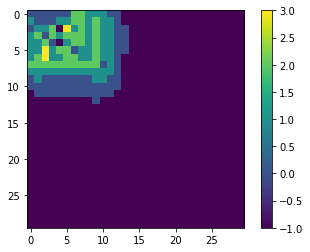

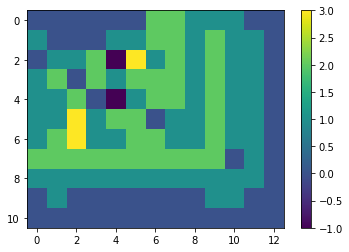

|0000002211100|1000112212110|0112-131212110|1202122212110|1120-112212110|1131220112110|1231122112110|2222222222010|1111111111110|0100000001100|0000000000000|
2697da3f_0 |0000002211100|1000112212110|0112-131212110|1202122212110|1120-112212110|1131220112110|1231122112110|2222222222010|1111111111110|0100000001100|0000000000000|


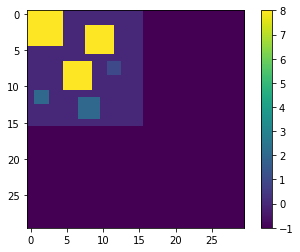

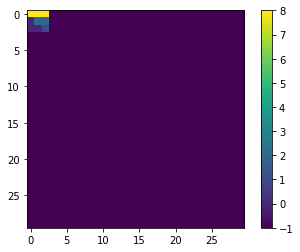

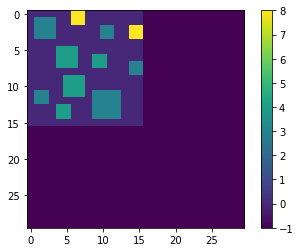


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

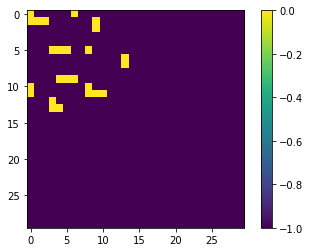

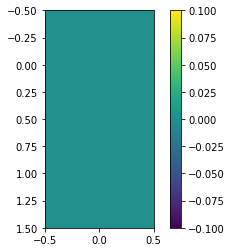

|0|0|
2753e76c_0 |0|0|


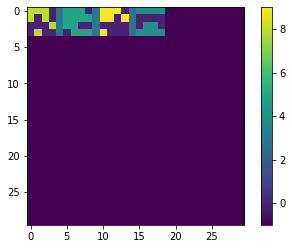

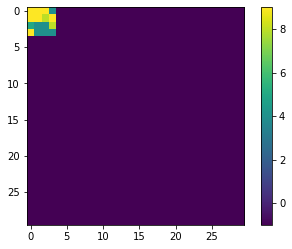

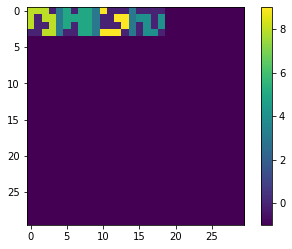


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

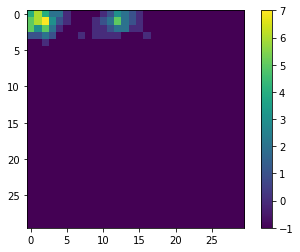

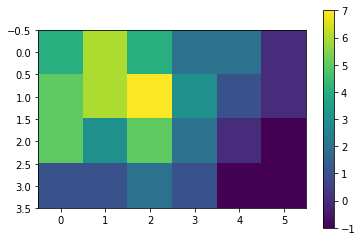

|464220|567310|53520-1|1121-1-1|
281123b4_0 |464220|567310|53520-1|1121-1-1|


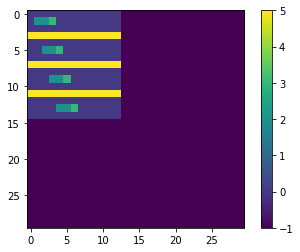

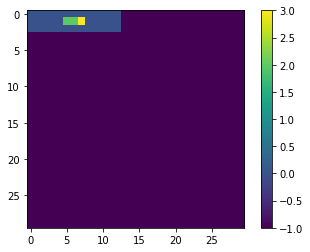

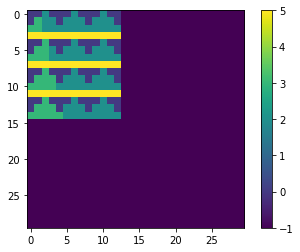


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

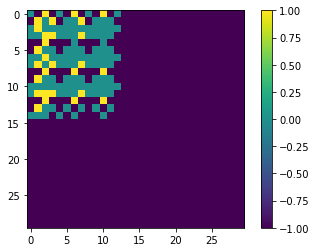

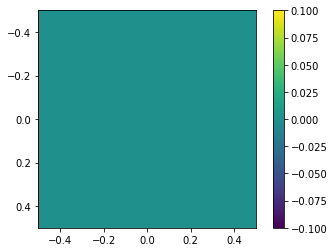

|0|
351d6448_0 |0|


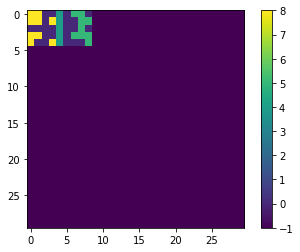

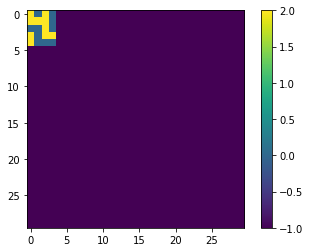

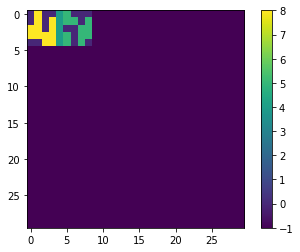


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

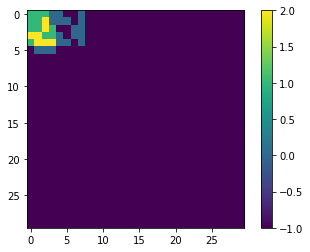

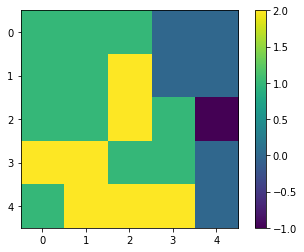

|11100|11200|1121-1|22110|12220|
34b99a2b_0 |11100|11200|1121-1|22110|12220|


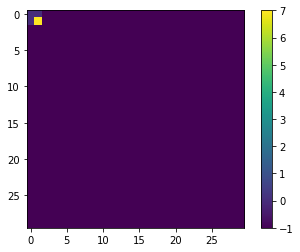

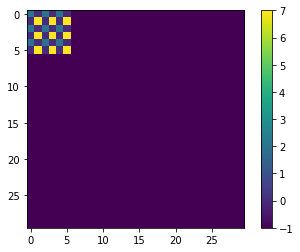

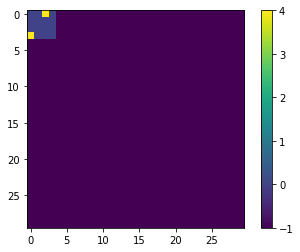


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

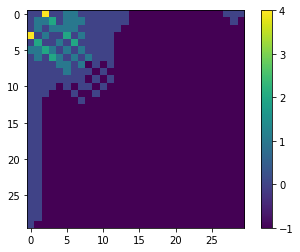

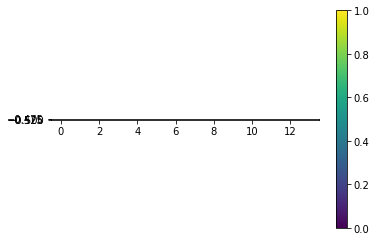

[]


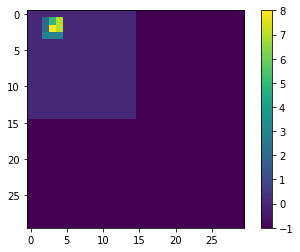

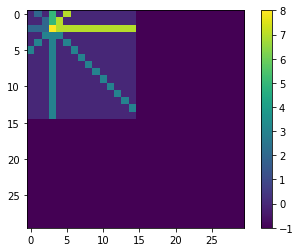

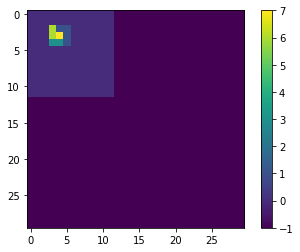


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 2, 30, 30, 1

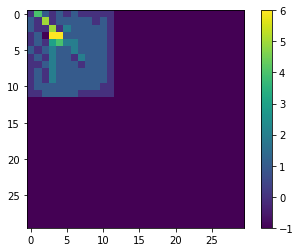

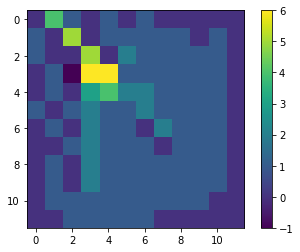

|041010100000|105011111010|100502111110|01-1661111110|010342211110|101211211110|010211021110|001211101110|010211111110|010211111110|011111111100|001111100000|
(30, 30, 18)


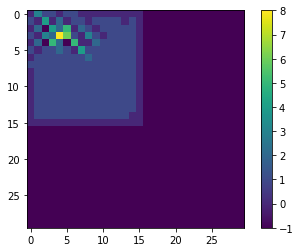

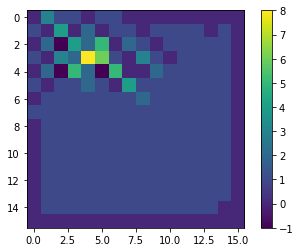

|0311011000000000|1040201101111010|02-14250210111110|1032861031011110|02-152-15002111110|1011210411111110|0111111121111110|1111111111111110|0111111111111110|0111111111111110|0111111111111110|0111111111111110|0111111111111110|0111111111111110|0111111111111100|0000000000000000|
1d398264_0 |041010100000|105011111010|100502111110|01-1661111110|010342211110|101211211110|010211021110|001211101110|010211111110|010211111110|011111111100|001111100000|
1d398264_1 |0311011000000000|1040201101111010|02-14250210111110|1032861031011110|02-152-15002111110|1011210411111110|0111111121111110|1111111111111110|0111111111111110|0111111111111110|0111111111111110|0111111111111110|0111111111111110|0111111111111110|0111111111111100|0000000000000000|


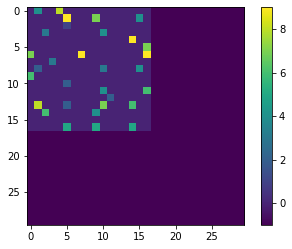

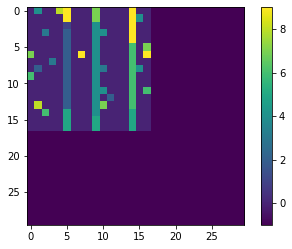

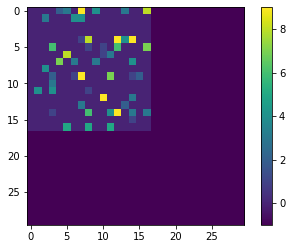


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

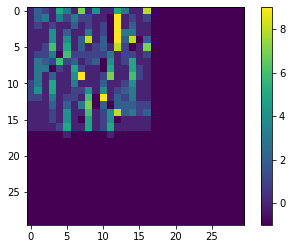

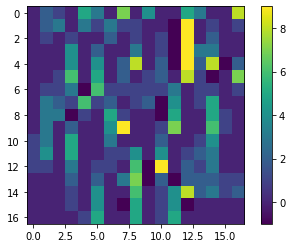

|02105307040053008|02303131100-190101|01010020101-190200|00040200301-193300|00040402802-1928-12|00160502012081-107|0113-1611111301101|0321612012-1401500|033-1105100-1500510|03020049001700610|13050030002001400|14050011404012300|110301106-19021300|000202037-12-122211|00010400601482312|0001040-15014-10000|00001500501500000|
17b80ad2_0 |02105307040053008|02303131100-190101|01010020101-190200|00040200301-193300|00040402802-1928-12|00160502012081-107|0113-1611111301101|0321612012-1401500|033-1105100-1500510|03020049001700610|13050030002001400|14050011404012300|110301106-19021300|000202037-12-122211|00010400601482312|0001040-15014-10000|00001500501500000|


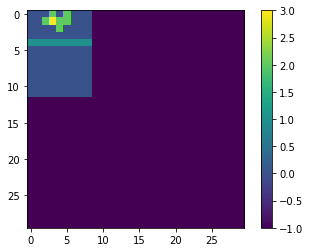

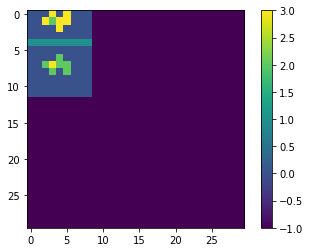

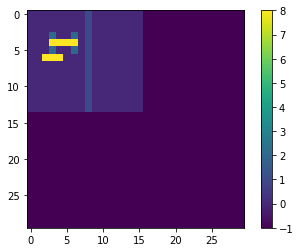


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

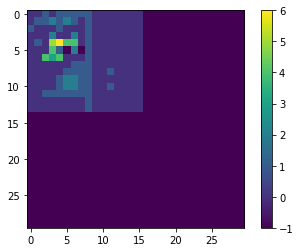

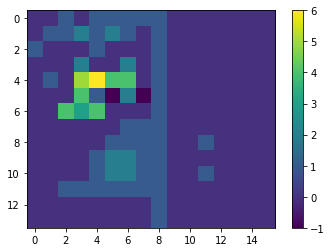

|0010111110000000|0112121010000000|1000100010000000|0002002010000000|0105644010000000|00041-12-110000000|0043400010000000|0000001110000000|0000011110010000|0000122110000000|0000122110010000|0011111110000000|0000000010000000|0000000010000000|
2b01abd0_0 |0010111110000000|0112121010000000|1000100010000000|0002002010000000|0105644010000000|00041-12-110000000|0043400010000000|0000001110000000|0000011110010000|0000122110000000|0000122110010000|0011111110000000|0000000010000000|0000000010000000|


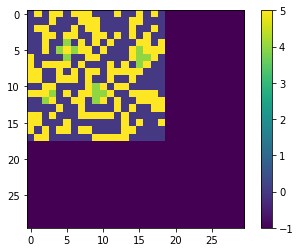

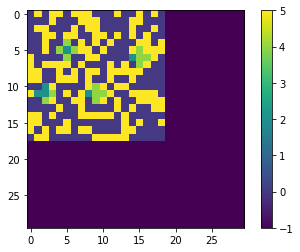

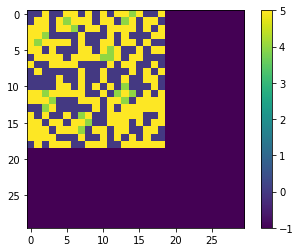


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

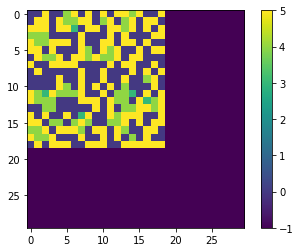

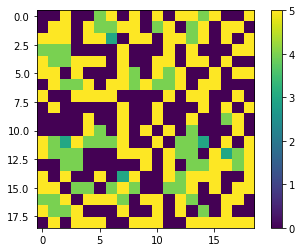

|0050045050505545005|0550544550450450550|5550553055055450505|4440000500050500055|5445550500550550500|5505000540545005055|0544505545445055000|5005555000050550050|0500000500500050505|0000500500500500450|0000540505050400050|5435444500504430505|5444000555054405345|0044000005050445545|5050050350054555005|5504404540044505055|4450555405505400550|5445000500505040500|0505550055500555555|
14754a24_0 |0050045050505545005|0550544550450450550|5550553055055450505|4440000500050500055|5445550500550550500|5505000540545005055|0544505545445055000|5005555000050550050|0500000500500050505|0000500500500500450|0000540505050400050|5435444500504430505|5444000555054405345|0044000005050445545|5050050350054555005|5504404540044505055|4450555405505400550|5445000500505040500|0505550055500555555|


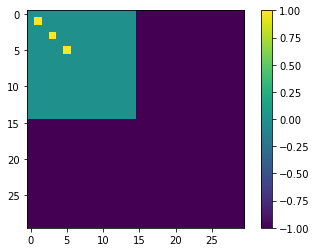

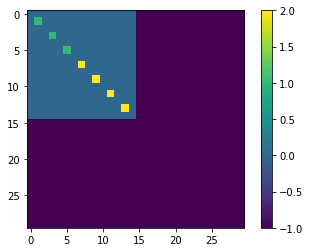

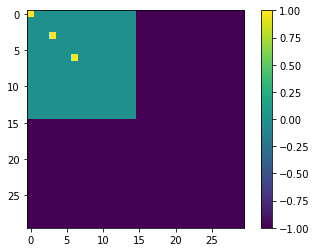


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

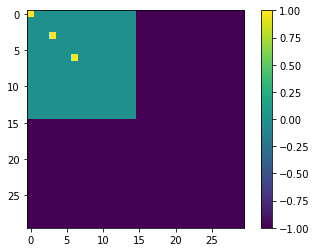

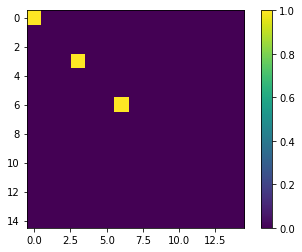

|100000000000000|000000000000000|000000000000000|000100000000000|000000000000000|000000000000000|000000100000000|000000000000000|000000000000000|000000000000000|000000000000000|000000000000000|000000000000000|000000000000000|000000000000000|
0b17323b_0 |100000000000000|000000000000000|000000000000000|000100000000000|000000000000000|000000000000000|000000100000000|000000000000000|000000000000000|000000000000000|000000000000000|000000000000000|000000000000000|000000000000000|000000000000000|


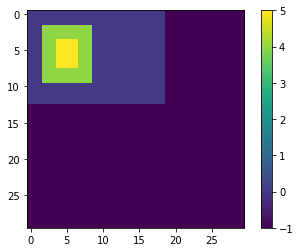

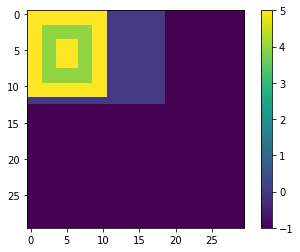

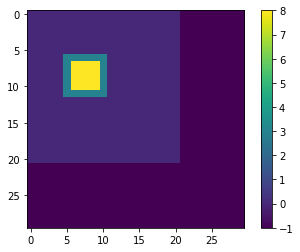


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

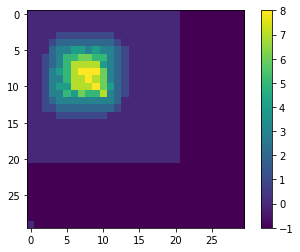

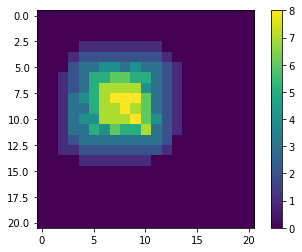

|000000000000000000000|000000000000000000000|000000000000000000000|000011111111000000000|000122222222100000000|000233443433210000000|001235566553210000000|001235777743210000000|001345788863210000000|001335778763210000000|001344777864210000000|001335465573210000000|001233333333200000000|001122222222100000000|000011111110000000000|000000000000000000000|000000000000000000000|000000000000000000000|000000000000000000000|000000000000000000000|000000000000000000000|
3a301edc_0 |000000000000000000000|000000000000000000000|000000000000000000000|000011111111000000000|000122222222100000000|000233443433210000000|001235566553210000000|001235777743210000000|001345788863210000000|001335778763210000000|001344777864210000000|001335465573210000000|001233333333200000000|001122222222100000000|000011111110000000000|000000000000000000000|000000000000000000000|000000000000000000000|000000000000000000000|000000000000000000000|000000000000000000000|


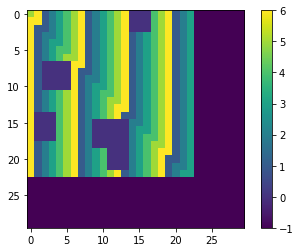

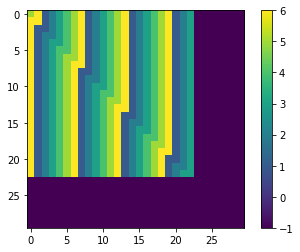

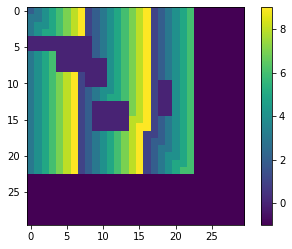


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

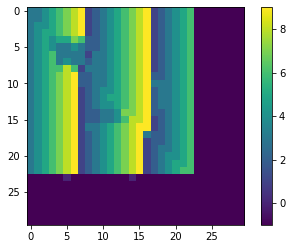

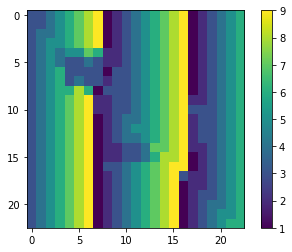

|33456789123456789123456|33456789123456789123456|34456789123456789123456|34556789123456789123456|34545576223456789123456|34543343223456789123456|34563333133456789123456|34563433233456789123456|34566861333456789123456|34567892233456789223456|34567892233456789333456|34567891234456789233456|34567891234556789233456|34567891234456789233456|34567891223347789223456|34567891223346889123456|34567891334567899123456|34567891234567893223456|34567891234567891223456|34567891234567891233456|34567891234567891234456|34567891234567891234556|34567891234567891234566|
1e97544e_0 |33456789123456789123456|33456789123456789123456|34456789123456789123456|34556789123456789123456|34545576223456789123456|34543343223456789123456|34563333133456789123456|34563433233456789123456|34566861333456789123456|34567892233456789223456|34567892233456789333456|34567891234456789233456|34567891234556789233456|34567891234456789233456|34567891223347789223456|34567891223346889123456|34567891334567899123456|34567891234567893223456|34

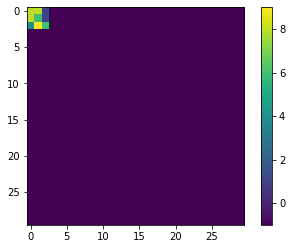

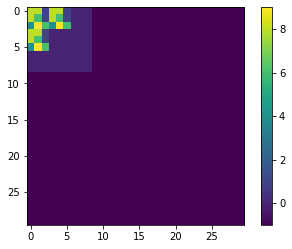

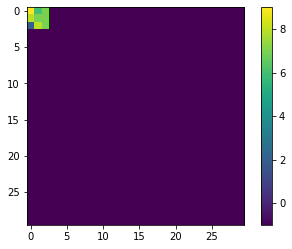


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

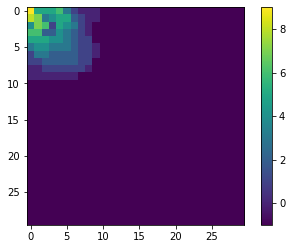

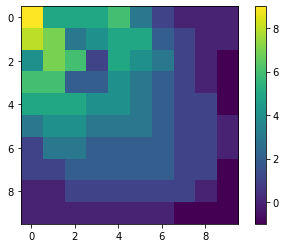

|9555631000|8734552100|476154310-1|662243210-1|555443211-1|3443332110|1332222110|112222211-1|001111110-1|0000000-1-1-1|
27f8ce4f_0 |9555631000|8734552100|476154310-1|662243210-1|555443211-1|3443332110|1332222110|112222211-1|001111110-1|0000000-1-1-1|


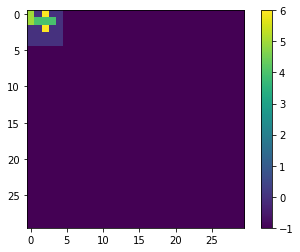

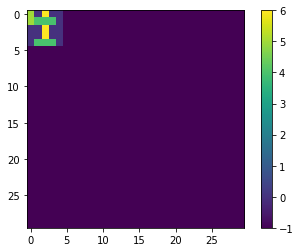

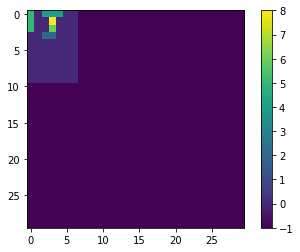


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

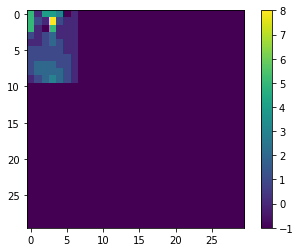

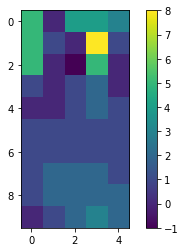

|50443|51081|50-150|10120|00121|11111|11111|12221|12222|01232|
12422b43_0 |50443|51081|50-150|10120|00121|11111|11111|12221|12222|01232|


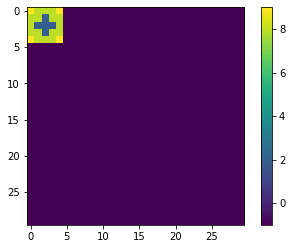

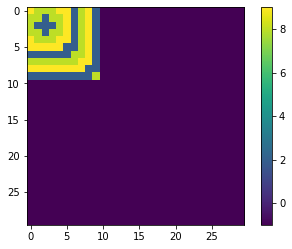

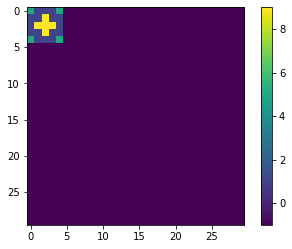


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

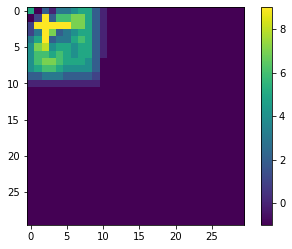

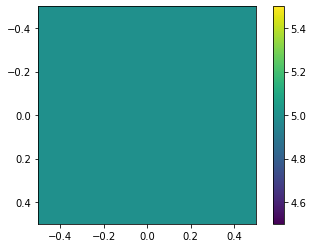

|5|
3979b1a8_0 |5|


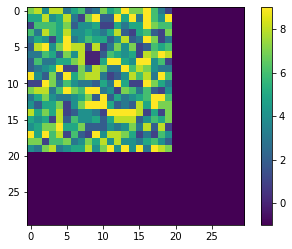

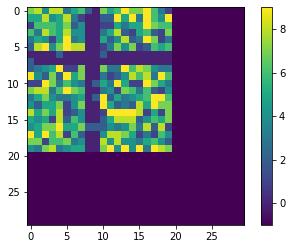

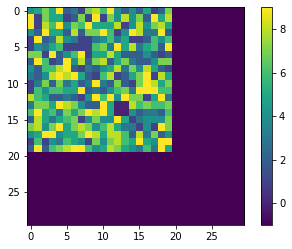


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

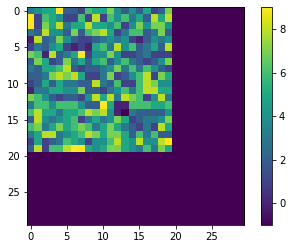

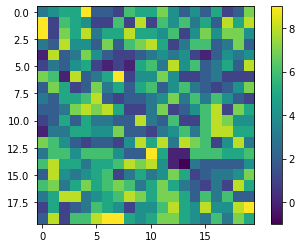

|34559221655742425127|91654116181646352858|91758355855461474774|32844272678513662372|08237421123434102434|13245101056384623528|76082359144741123111|27512735256246321247|32556821223473636421|22378785113712468175|12525332283261168744|03355447221346368855|76421221485838761483|36646664229500666556|6855355687840-1322224|28434561353475123347|67357567635753213185|35883456875775263622|15123654144685484489|28166899545775436375|
319f2597_0 |34559221655742425127|91654116181646352858|91758355855461474774|32844272678513662372|08237421123434102434|13245101056384623528|76082359144741123111|27512735256246321247|32556821223473636421|22378785113712468175|12525332283261168744|03355447221346368855|76421221485838761483|36646664229500666556|6855355687840-1322224|28434561353475123347|67357567635753213185|35883456875775263622|15123654144685484489|28166899545775436375|


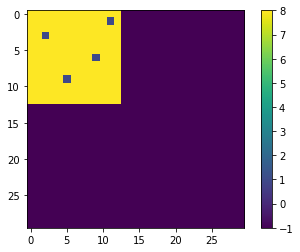

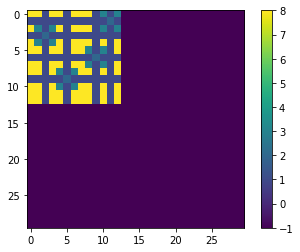

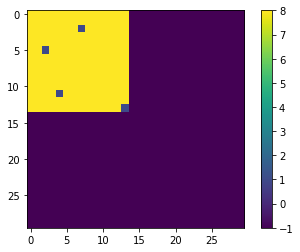


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

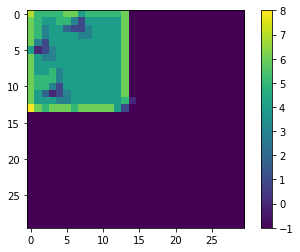

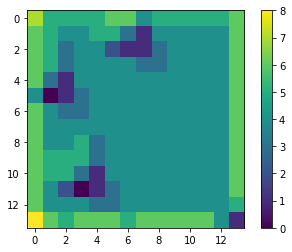

|75555664555556|65445531444446|65344211344446|65344443344446|63144444444446|40134444444446|64334444444446|64444444444446|64453444444446|65553444444446|65531444444446|64201344444446|64443344444445|86566656666641|
140c817e_0 |75555664555556|65445531444446|65344211344446|65344443344446|63144444444446|40134444444446|64334444444446|64444444444446|64453444444446|65553444444446|65531444444446|64201344444446|64443344444445|86566656666641|


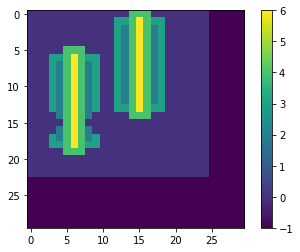

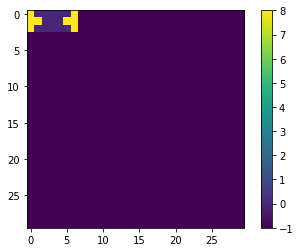

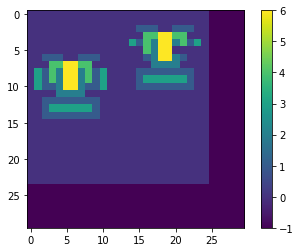


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

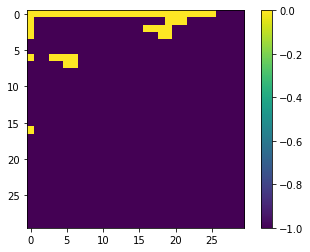

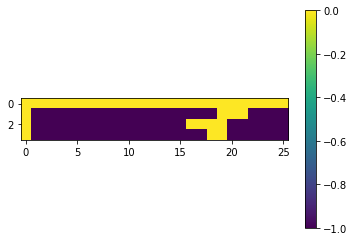

|00000000000000000000000000|0-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1000-1-1-1-1|0-1-1-1-1-1-1-1-1-1-1-1-1-1-1-10000-1-1-1-1-1-1|0-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-100-1-1-1-1-1-1|
2037f2c7_0 |00000000000000000000000000|0-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1000-1-1-1-1|0-1-1-1-1-1-1-1-1-1-1-1-1-1-1-10000-1-1-1-1-1-1|0-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-100-1-1-1-1-1-1|


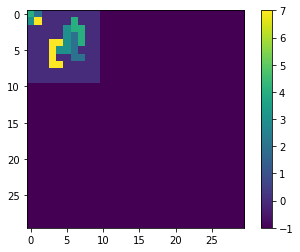

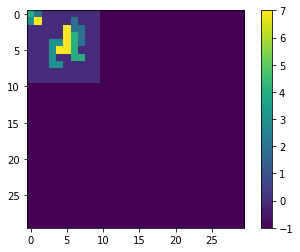

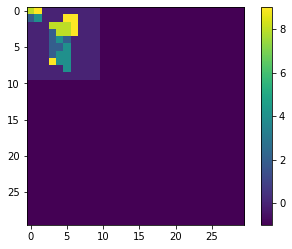


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

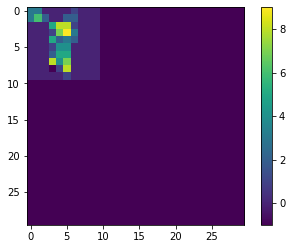

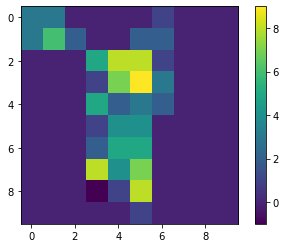

|3300001000|3620022000|0005881000|0001793000|0005232000|0001440000|0002550000|0008470000|000-1180000|0000010000|
0becf7df_0 |3300001000|3620022000|0005881000|0001793000|0005232000|0001440000|0002550000|0008470000|000-1180000|0000010000|


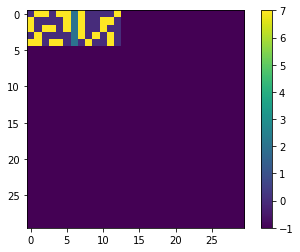

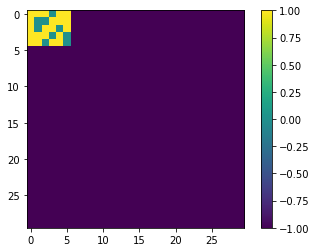

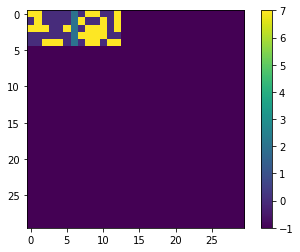


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

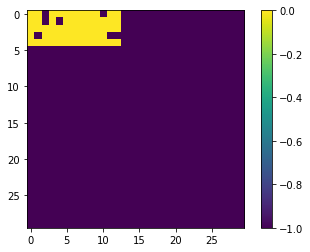

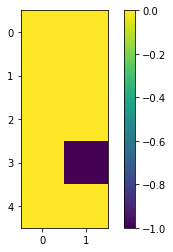

|00|00|00|0-1|00|
195ba7dc_0 |00|00|00|0-1|00|


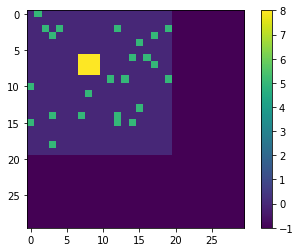

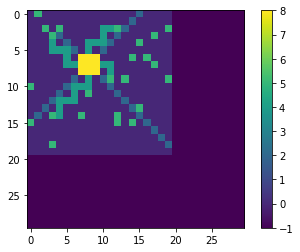

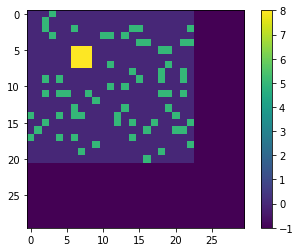


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

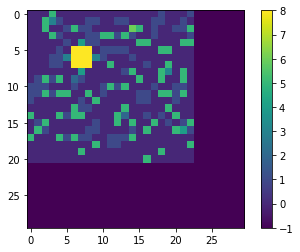

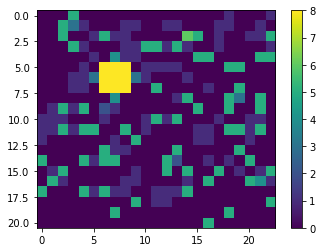

|00050000000000000010001|00531000110011000110010|00500151100000650100115|00051000115515100100001|00000104110000055000055|00001088801111000055000|00011388831000100000000|00011088800500001005000|00000004000001500053050|01515021000000050050050|11100010001515000100110|11515500501000011055150|10000001050000011000100|00000051100005000005000|50005155000052001010500|01500000010050500501015|05100000110000105000541|50005151100111500000000|00000000050110000000005|00000005000000000050000|00000000000000005000000|
212895b5_0 |00050000000000000010001|00531000110011000110010|00500151100000650100115|00051000115515100100001|00000104110000055000055|00001088801111000055000|00011388831000100000000|00011088800500001005000|00000004000001500053050|01515021000000050050050|11100010001515000100110|11515500501000011055150|10000001050000011000100|00000051100005000005000|50005155000052001010500|01500000010050500501015|05100000110000105000541|50005151100111500000000|00000000050110000000005|00000005000000000050000|00

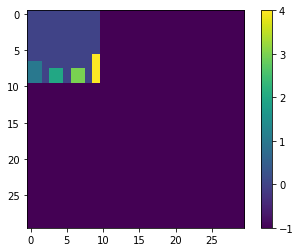

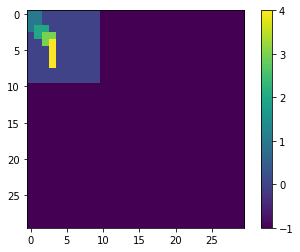

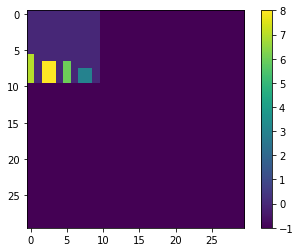


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

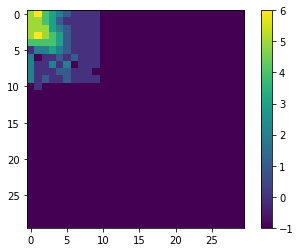

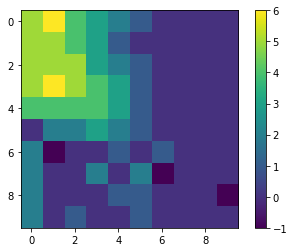

|5643210000|5543100000|5553210000|5654310000|4444310000|0223210000|2-100101000|200202-1000|200011000-1|2010010000|
03560426_0 |5643210000|5543100000|5553210000|5654310000|4444310000|0223210000|2-100101000|200202-1000|200011000-1|2010010000|


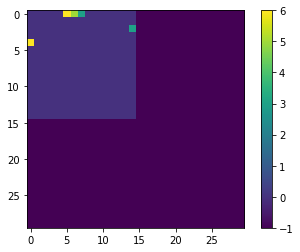

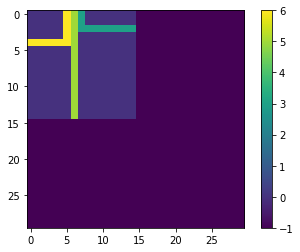

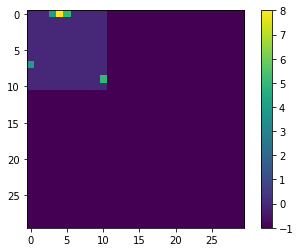


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

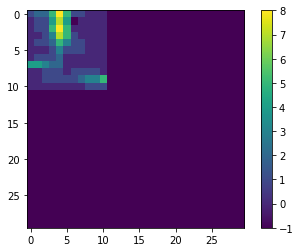

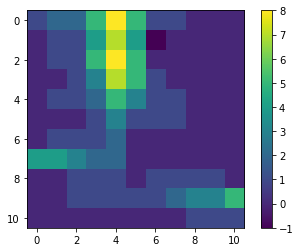

|12258511000|011474-10000|01158500000|00137510000|01125311000|00013111000|01112000000|44322000000|00111011110|00111112335|00000000111|
29700607_0 |12258511000|011474-10000|01158500000|00137510000|01125311000|00013111000|01112000000|44322000000|00111011110|00111112335|00000000111|


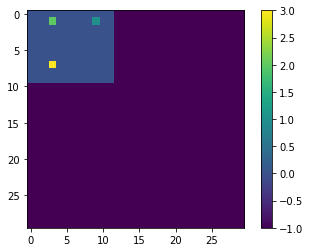

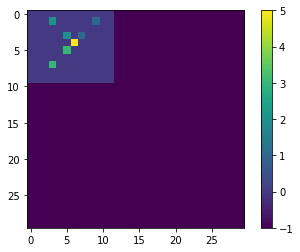

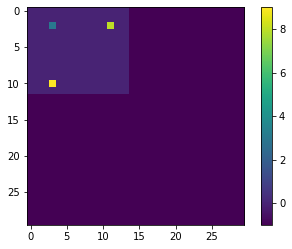


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

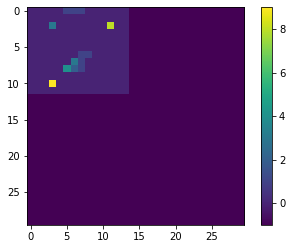

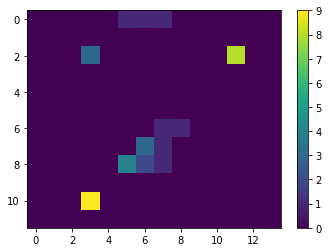

|00000111000000|00000000000000|00030000000800|00000000000000|00000000000000|00000000000000|00000001100000|00000031000000|00000421000000|00000000000000|00090000000000|00000000000000|
11e1fe23_0 |00000111000000|00000000000000|00030000000800|00000000000000|00000000000000|00000000000000|00000001100000|00000031000000|00000421000000|00000000000000|00090000000000|00000000000000|


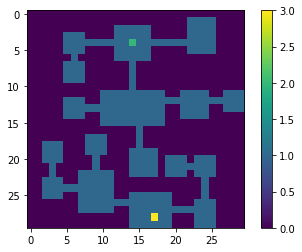

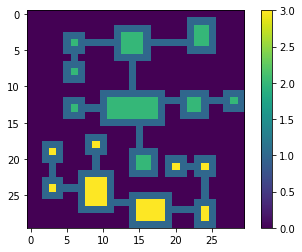

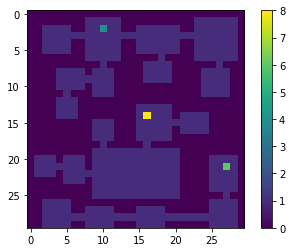


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

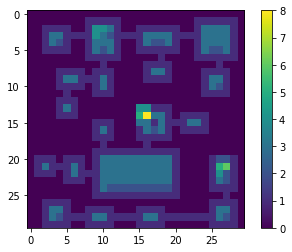

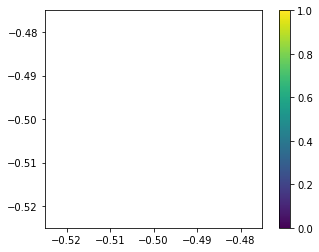

[]


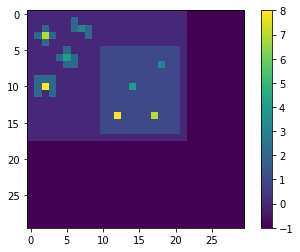

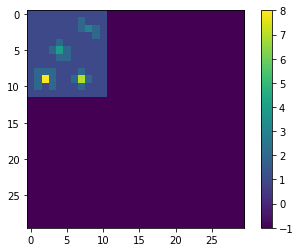

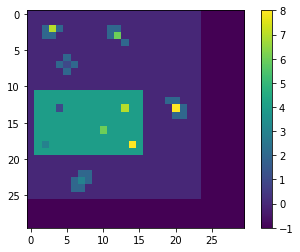


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

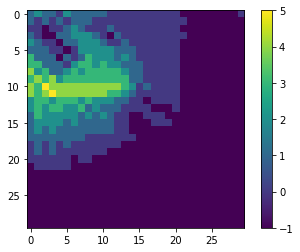

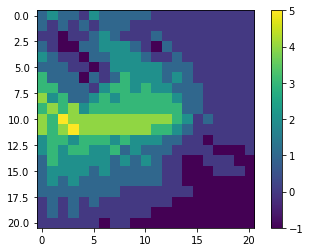

|121102111110000000000|101010111000000000000|00-1001210001000000000|10-1-11122210-1100000000|2100-11122210010000000|11100-1022222111000000|3111-11013222121000000|331110233232211100000|423112323333321100000|343423333333331100000|435444444444432010000|434544444443321000000|2332333232221100-10000|23233223121110000-1-1-10|13222221212100-1-1000-1-1|12222121111100-1-1-1000-1|12121111111100-1-1-1-1-1-1-1|111111110000000-1-1-1-1-1-1|0101010000000-1-1-1-1-1-1-1-1|01010000000-1-1-1-1-1-1-1-1-1-1|000000-100-1-1-1-1-1-1-1-1-1-1-1-1|
414297c0_0 |121102111110000000000|101010111000000000000|00-1001210001000000000|10-1-11122210-1100000000|2100-11122210010000000|11100-1022222111000000|3111-11013222121000000|331110233232211100000|423112323333321100000|343423333333331100000|435444444444432010000|434544444443321000000|2332333232221100-10000|23233223121110000-1-1-10|13222221212100-1-1000-1-1|12222121111100-1-1-1000-1|12121111111100-1-1-1-1-1-1-1|111111110000000-1-1-1-1-1-1|0101010000000-1-1-1-1-1-1-1-1|010

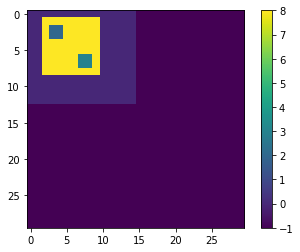

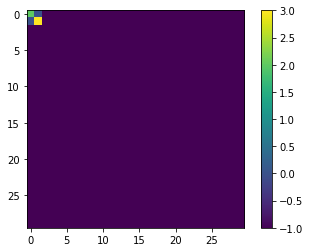

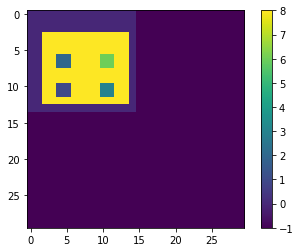


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

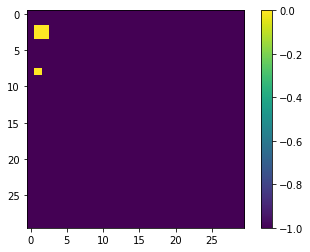

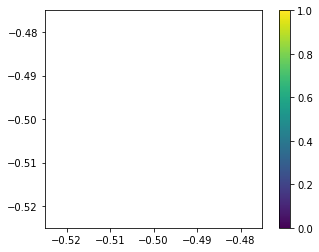

[]


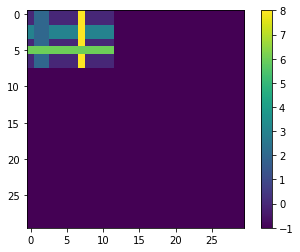

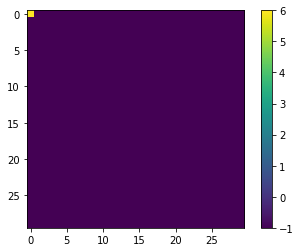

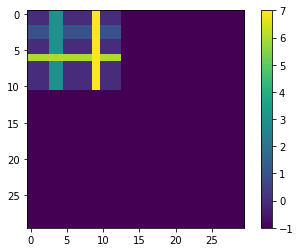


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

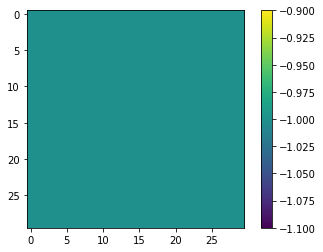

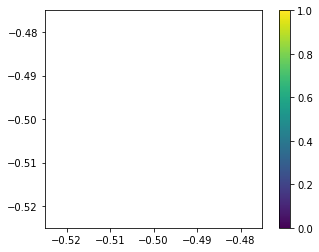

[]


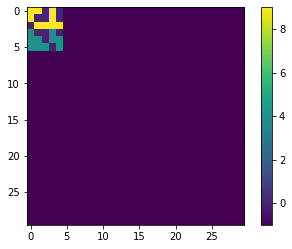

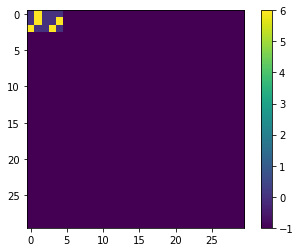

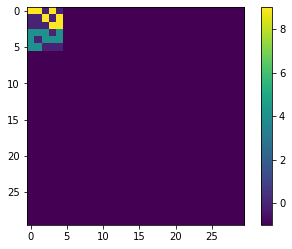


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 2, 30, 30, 1

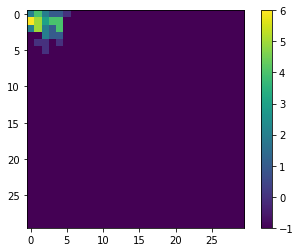

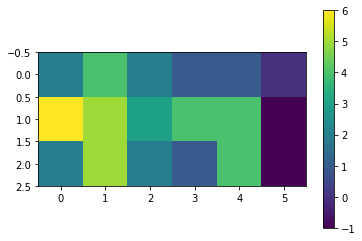

|242110|65344-1|25214-1|
(30, 30, 18)


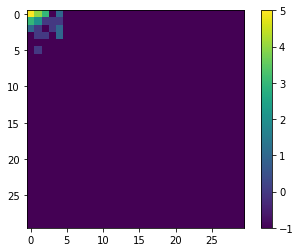

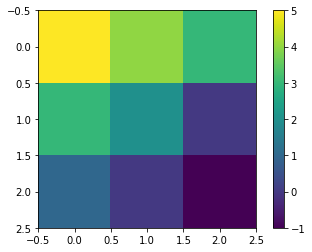

|543|320|10-1|
31d5ba1a_0 |242110|65344-1|25214-1|
31d5ba1a_1 |543|320|10-1|


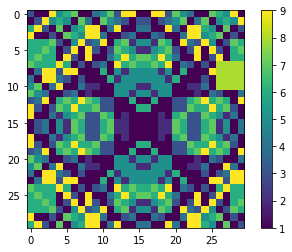

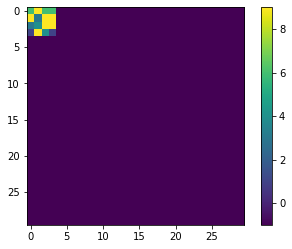

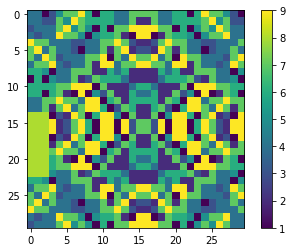


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

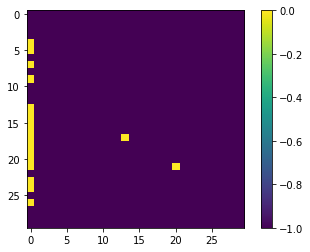

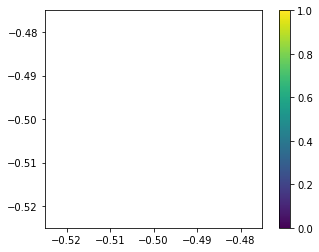

[]


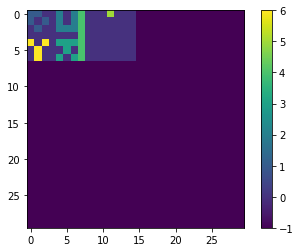

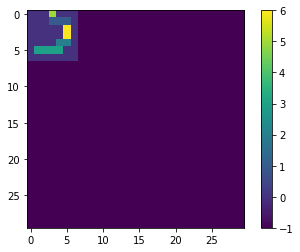

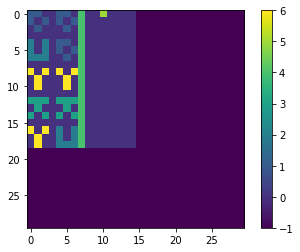


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

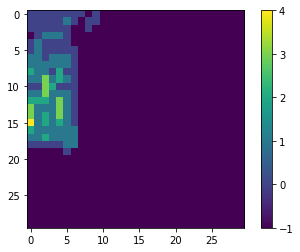

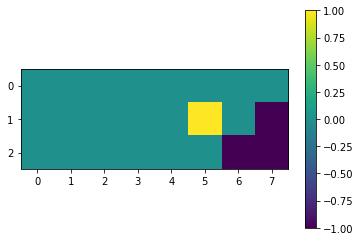

|00000000|0000010-1|000000-1-1|
136b0064_0 |00000000|0000010-1|000000-1-1|


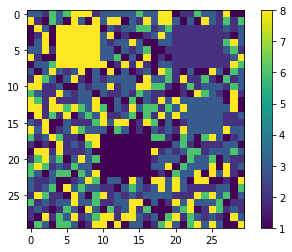

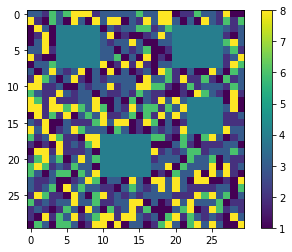

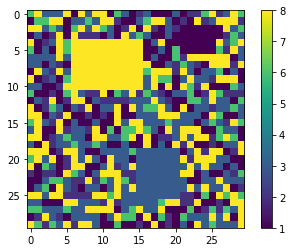


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

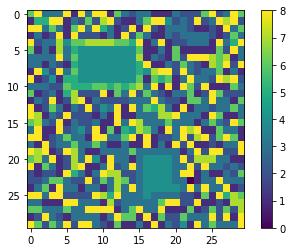

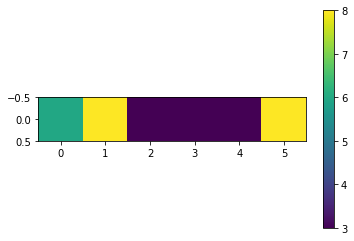

|683338|
25094a63_0 |683338|


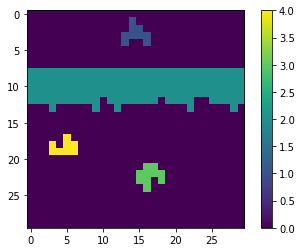

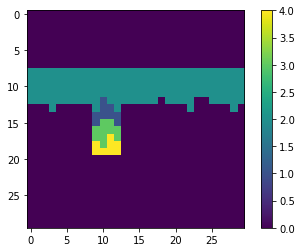

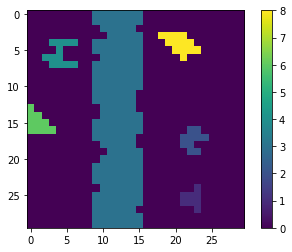


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

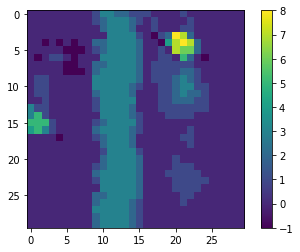

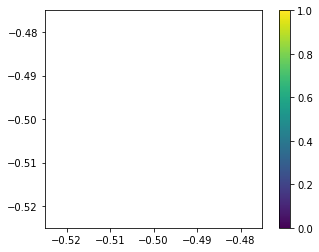

[]


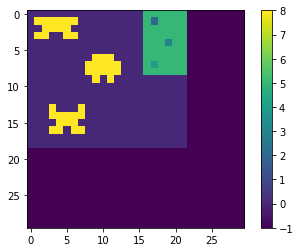

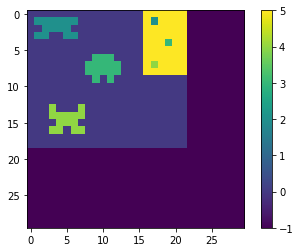

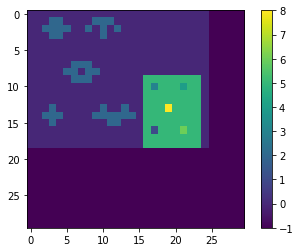


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

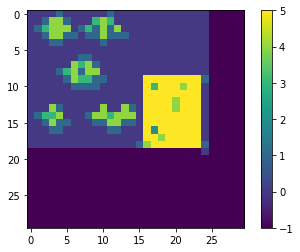

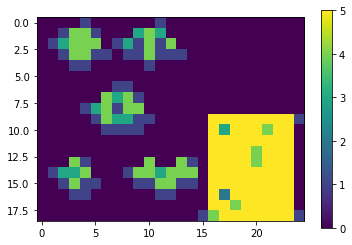

|0000100000010000000000000|0014410003430000000000000|0134440131414000000000000|0014411011411100000000000|0001100000100000000000000|0000000000000000000000000|0000000110000000000000000|0000004341000000000000000|0000134144000000000000000|0000014331100000555555551|0000001111000000535554550|0000000000000000555555550|0000000000000000555545550|0004100000400410555545550|0133400014434440555555550|0014110001144110555555550|0001100000011000525555550|0000000000000000554555550|0000000000000001455555551|
1da012fc_0 |0000100000010000000000000|0014410003430000000000000|0134440131414000000000000|0014411011411100000000000|0001100000100000000000000|0000000000000000000000000|0000000110000000000000000|0000004341000000000000000|0000134144000000000000000|0000014331100000555555551|0000001111000000535554550|0000000000000000555555550|0000000000000000555545550|0004100000400410555545550|0133400014434440555555550|0014110001144110555555550|0001100000011000525555550|0000000000000000554555550|000000000000000145555555

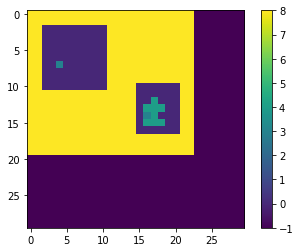

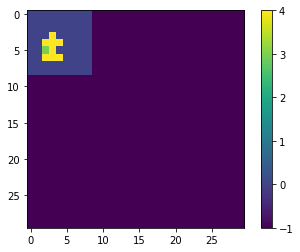

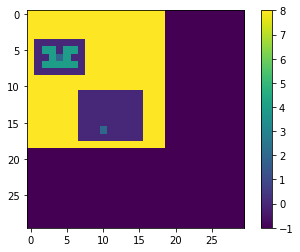


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

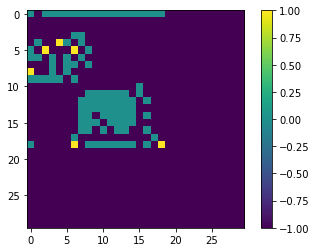

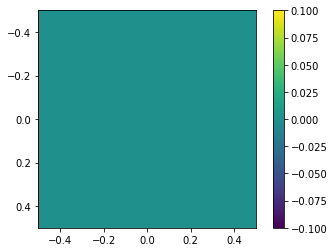

|0|
2f0c5170_0 |0|


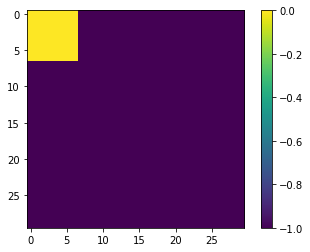

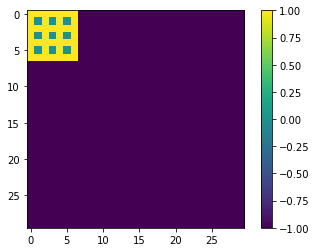

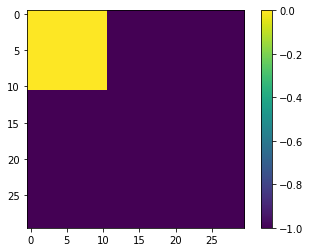


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

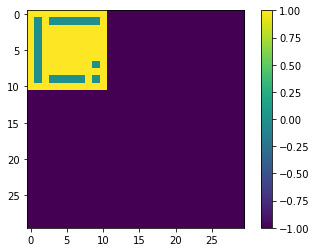

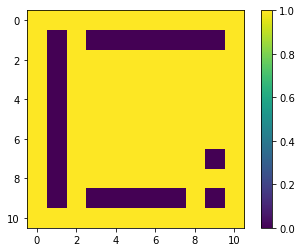

|11111111111|10100000001|10111111111|10111111111|10111111111|10111111111|10111111111|10111111101|10111111111|10100000101|11111111111|
332efdb3_0 |11111111111|10100000001|10111111111|10111111111|10111111111|10111111111|10111111111|10111111101|10111111111|10100000101|11111111111|


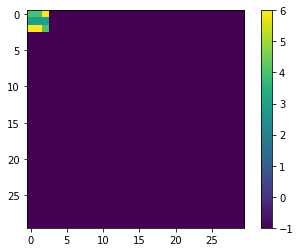

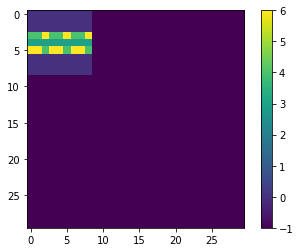

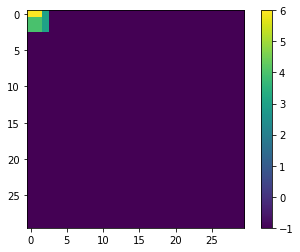


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

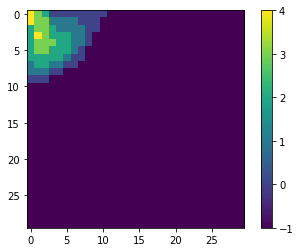

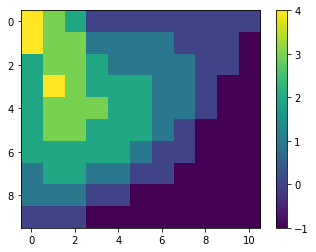

|43200000000|4331111000-1|2332111100-1|243222110-1-1|233322110-1-1|23322210-1-1-1|22222100-1-1-1|1221100-1-1-1-1|11100-1-1-1-1-1-1|000-1-1-1-1-1-1-1-1|
15696249_0 |43200000000|4331111000-1|2332111100-1|243222110-1-1|233322110-1-1|23322210-1-1-1|22222100-1-1-1|1221100-1-1-1-1|11100-1-1-1-1-1-1|000-1-1-1-1-1-1-1-1|


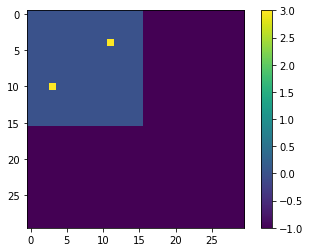

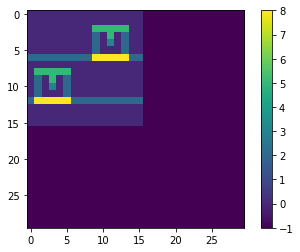

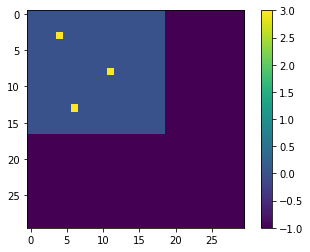


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

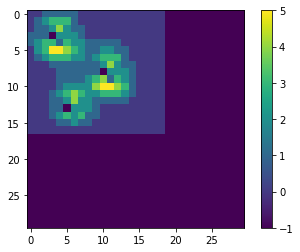

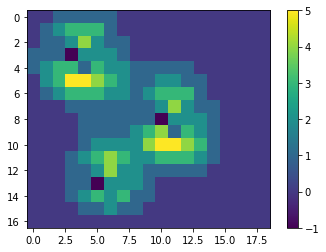

|0011111000000000000|0123331000000000000|0112421100000000000|111-1222100000000000|1233132211111000000|0235543211221100000|0123332212333100000|0001111111242110000|0000111111-122210000|0000111123413210000|0000122224554310000|0001234322333210000|0001124221111100000|00011-12221000000000|0001232311000000000|0000112110000000000|0000000000000000000|
3f23242b_0 |0011111000000000000|0123331000000000000|0112421100000000000|111-1222100000000000|1233132211111000000|0235543211221100000|0123332212333100000|0001111111242110000|0000111111-122210000|0000111123413210000|0000122224554310000|0001234322333210000|0001124221111100000|00011-12221000000000|0001232311000000000|0000112110000000000|0000000000000000000|


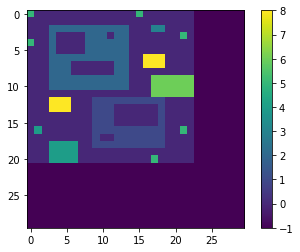

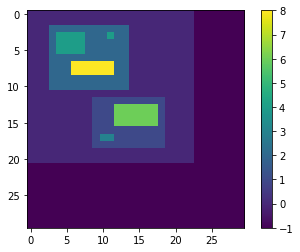

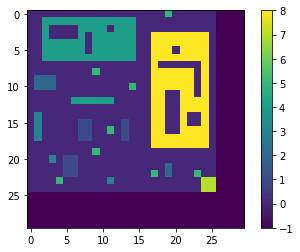


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

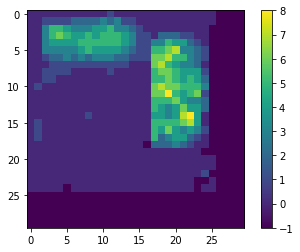

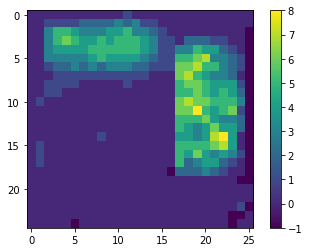

|00000000000100000000000000|00111122223231100000000000|0035543334453321000000000-1|0035654454555431102221100-1|0034444555555431133544210-1|0033333454444321155673321-1|0012232323332211166755321-1|0001111111111100067543320-1|0011110000010000056654441-1|0011000000000000055654542-1|0100000000000000067665553-1|0000000000000000066854561-1|0000000000000000055564332-1|0000000000000000054346442-1|0000000010000000044347840-1|0100000000000000055556740-1|0100000000000000054643431-1|0100000000000000052344210-1|0000000000000000-122232100-1|000000000000000000000000-1-1|00000000000000000000000000|00000000000000000000000000|0000000000000000000000001-1|00000000000000000000000-1-10|00000-100000000000000000-100|
184a9768_0 |00000000000100000000000000|00111122223231100000000000|0035543334453321000000000-1|0035654454555431102221100-1|0034444555555431133544210-1|0033333454444321155673321-1|0012232323332211166755321-1|0001111111111100067543320-1|0011110000010000056654441-1|0011000000000000055654542-1|01000000

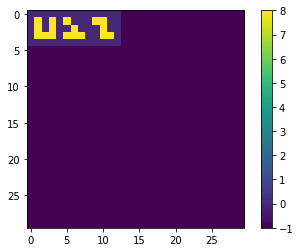

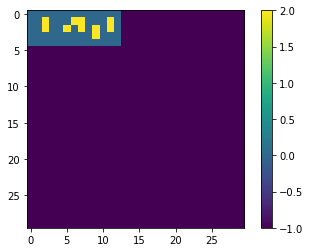

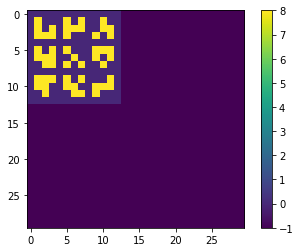


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

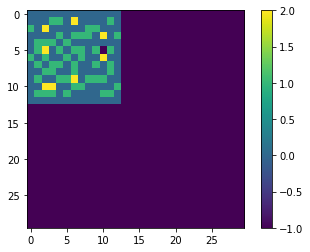

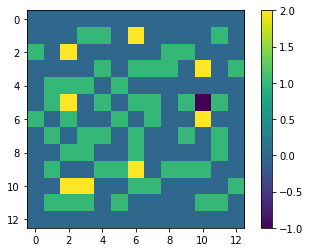

|0000000000000|0001102000010|1020000011000|0000101110201|0111010000000|0120101101-110|1010010100200|0101101001010|0011001000010|0100112011100|0022001100001|0111010000110|0000000000000|
1c0d0a4b_0 |0000000000000|0001102000010|1020000011000|0000101110201|0111010000000|0120101101-110|1010010100200|0101101001010|0011001000010|0100112011100|0022001100001|0111010000110|0000000000000|


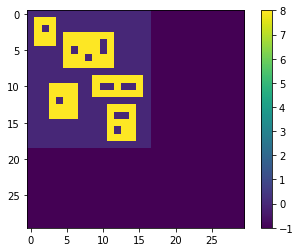

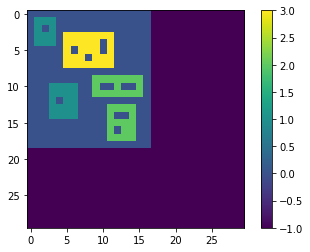

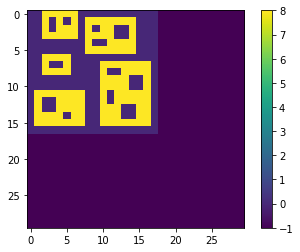


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

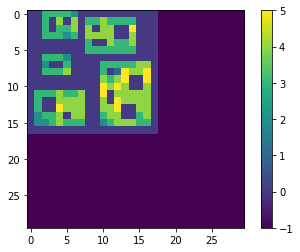

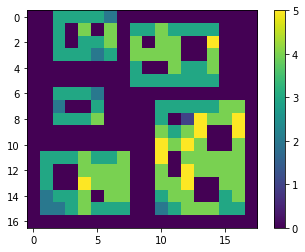

|003333200000000000|003040403343333000|003033404044005000|003332304444004000|000000003004334000|000000003333333000|003332000000000000|002003000033333440|003334000030154450|000000000043450050|000000000054540040|033343340050444440|030044440040544440|030054440044500440|023340440034400340|022343330023444330|000000000000000000|
37d3e8b2_0 |003333200000000000|003040403343333000|003033404044005000|003332304444004000|000000003004334000|000000003333333000|003332000000000000|002003000033333440|003334000030154450|000000000043450050|000000000054540040|033343340050444440|030044440040544440|030054440044500440|023340440034400340|022343330023444330|000000000000000000|


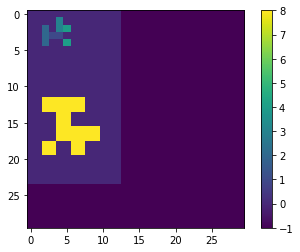

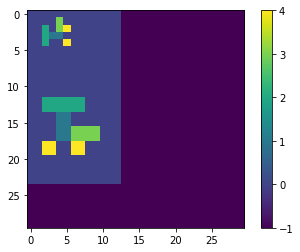

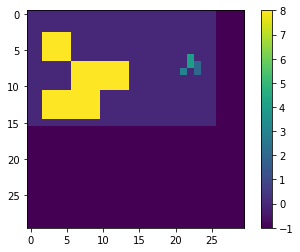


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

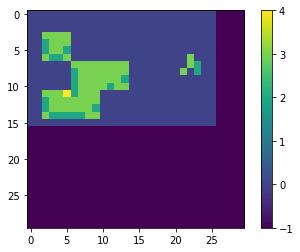

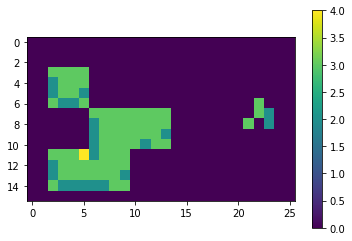

|00000000000000000000000000|00000000000000000000000000|00000000000000000000000000|00333300000000000000000000|00233300000000000000000000|00233200000000000000000000|00322300000000000000003000|00000033333333000000003200|00000023333333000000030200|00000023333332000000000000|00000023333233000000000000|00333423330000000000000000|00233333330000000000000000|00233333320000000000000000|00322222330000000000000000|00000000000000000000000000|
103eff5b_0 |00000000000000000000000000|00000000000000000000000000|00000000000000000000000000|00333300000000000000000000|00233300000000000000000000|00233200000000000000000000|00322300000000000000003000|00000033333333000000003200|00000023333333000000030200|00000023333332000000000000|00000023333233000000000000|00333423330000000000000000|00233333330000000000000000|00233333320000000000000000|00322222330000000000000000|00000000000000000000000000|


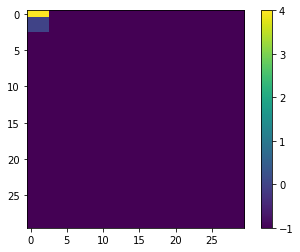

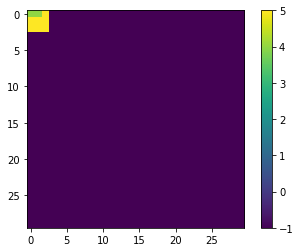

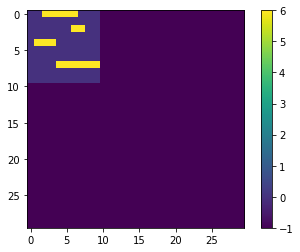


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

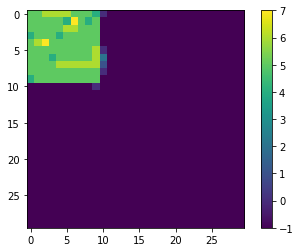

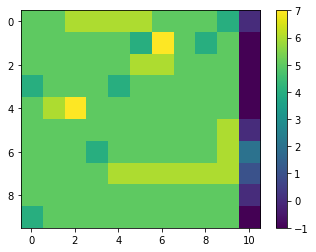

|55666655540|5555547545-1|5555566555-1|4555455555-1|5675555555-1|55555555560|55545555562|55556666661|55555555550|4555555555-1|
32e9702f_0 |55666655540|5555547545-1|5555566555-1|4555455555-1|5675555555-1|55555555560|55545555562|55556666661|55555555550|4555555555-1|


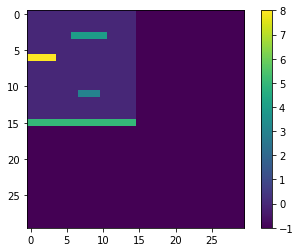

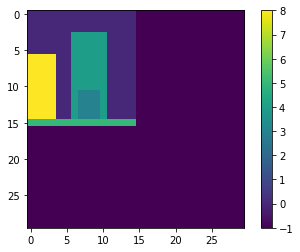

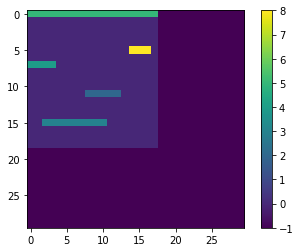


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

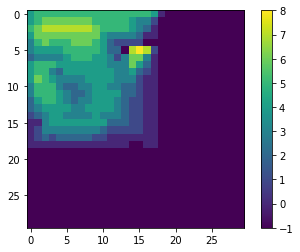

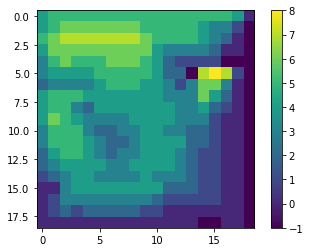

|4555555555555555540|456666666555554331-1|567777777655554320-1|466666666643333200-1|3565556665421111-1-1-1|3444455555422-17871-1|233334555443136630-1|455544444443336420-1|455324444444334210-1|465433334444333100-1|355532233443322100-1|355543223444422100-1|245543233444321100-1|234444334444321100-1|123443333433321100-1|003444444442221100-1|013333333321111100-1|012122222110000000-1|00000000000000-1-100-1|
13713586_0 |4555555555555555540|456666666555554331-1|567777777655554320-1|466666666643333200-1|3565556665421111-1-1-1|3444455555422-17871-1|233334555443136630-1|455544444443336420-1|455324444444334210-1|465433334444333100-1|355532233443322100-1|355543223444422100-1|245543233444321100-1|234444334444321100-1|123443333433321100-1|003444444442221100-1|013333333321111100-1|012122222110000000-1|00000000000000-1-100-1|


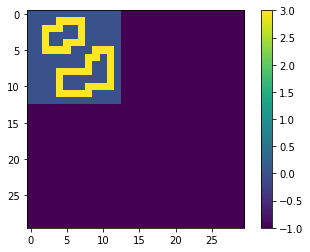

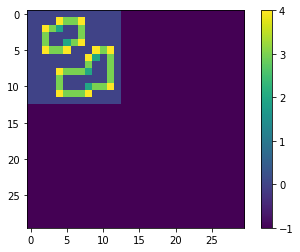

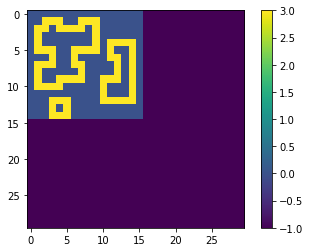


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

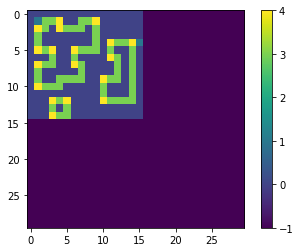

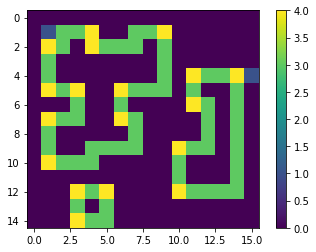

|0000000000000000|0133400334000000|0430433303000000|0300000003000000|0300000003043341|0434004333030030|0003003000043030|0433004300003030|0300000300003030|0300333300433030|0433300000300030|0000000000300030|0004340000433330|0003030000000000|0004330000000000|
15663ba9_0 |0000000000000000|0133400334000000|0430433303000000|0300000003000000|0300000003043341|0434004333030030|0003003000043030|0433004300003030|0300000300003030|0300333300433030|0433300000300030|0000000000300030|0004340000433330|0003030000000000|0004330000000000|


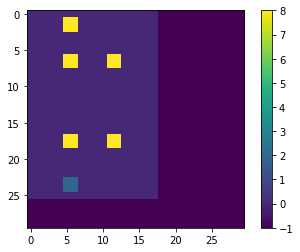

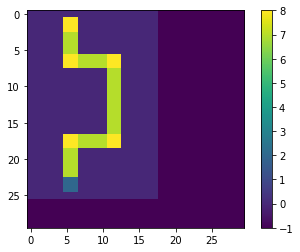

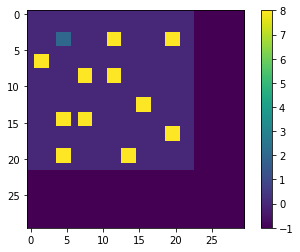


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

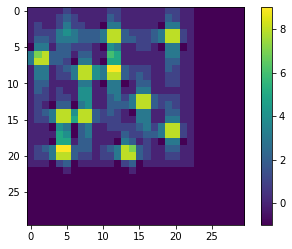

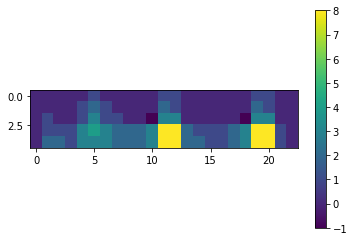

|00000100000110000001100|00001210000210000002100|0100131100-13300000-13300|01113432223882111238810|02213332223882211238810|
3490cc26_0 |00000100000110000001100|00001210000210000002100|0100131100-13300000-13300|01113432223882111238810|02213332223882211238810|


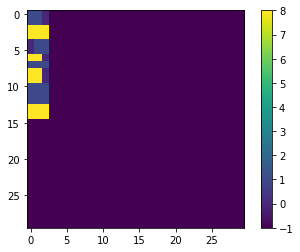

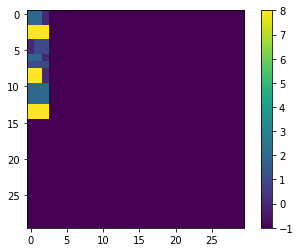

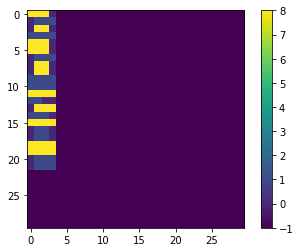


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

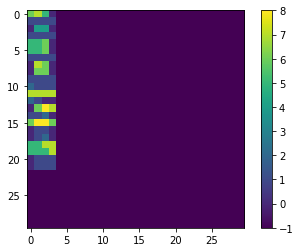

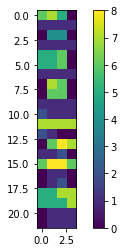

|6750|1111|0440|1111|5560|5560|1111|0760|0660|1111|2111|7777|2100|0687|1120|6886|0110|0120|5577|5557|0111|0111|
22a4bbc2_0 |6750|1111|0440|1111|5560|5560|1111|0760|0660|1111|2111|7777|2100|0687|1120|6886|0110|0120|5577|5557|0111|0111|


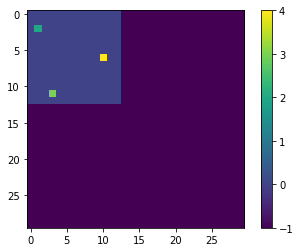

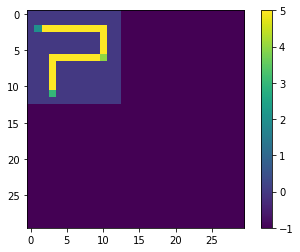

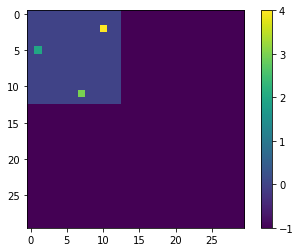


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

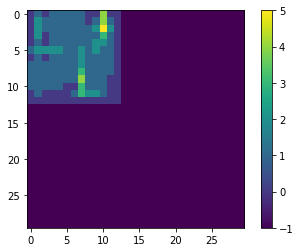

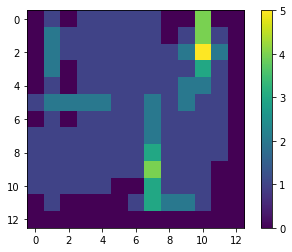

|0101111100400|0211111101410|0211111112520|0201111111310|0101111112210|1222211212110|0101111211110|1111111211110|1111111311110|1111111411100|1111100311100|0100001322100|0000000000000|
0e671a1a_0 |0101111100400|0211111101410|0211111112520|0201111111310|0101111112210|1222211212110|0101111211110|1111111211110|1111111311110|1111111411100|1111100311100|0100001322100|0000000000000|


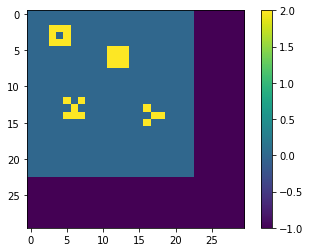

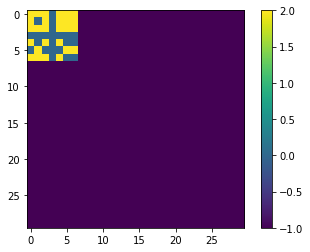

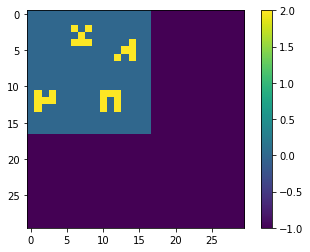


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

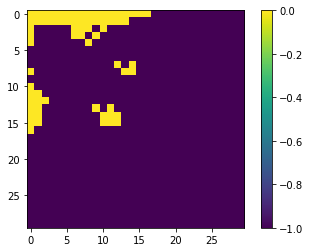

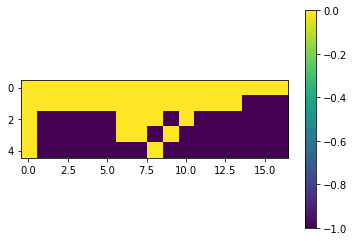

|00000000000000000|00000000000000-1-1-1|0-1-1-1-1-1000-10-1-1-1-1-1-1|0-1-1-1-1-100-10-1-1-1-1-1-1-1|0-1-1-1-1-1-1-10-1-1-1-1-1-1-1-1|
1990f7a8_0 |00000000000000000|00000000000000-1-1-1|0-1-1-1-1-1000-10-1-1-1-1-1-1|0-1-1-1-1-100-10-1-1-1-1-1-1-1|0-1-1-1-1-1-1-10-1-1-1-1-1-1-1-1|


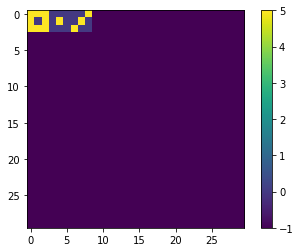

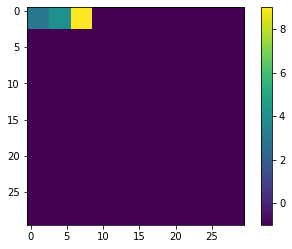

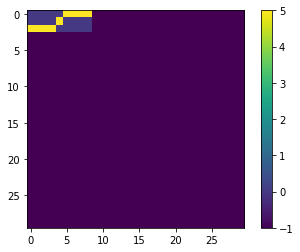


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(2, 1, 30, 30, 1

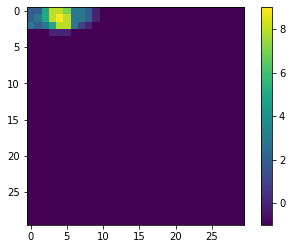

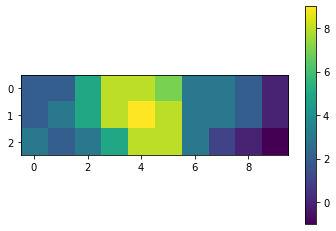

|2258873320|2358983320|323588310-1|
17cae0c1_0 |2258873320|2358983320|323588310-1|


In [12]:
with open('submission.csv', 'w', newline='') as outfile:
    writer = csv.writer(outfile, delimiter=',')
    writer.writerow(['output_id','output'])
    for name in names:
        solutions = solve(name)
        i = 0
        for s in solutions:
            if s != '[]':
                cname = ids[name]
                print(cname+"_"+str(i), s)
                writer.writerow([cname+"_"+str(i), s])
            i += 1
        outfile.flush()